In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import nltk
from datetime import datetime
import matplotlib.pyplot as plt


# Importing News Sources

In [2]:

df = pd.read_csv('/home/block/Documents/AppliedProject/Scrape/Assets/Bitcoinist.csv')
df1 = pd.read_csv('/home/block/Documents/AppliedProject/Scrape/Assets/Blockonomi.csv')
df2 = pd.read_csv('/home/block/Documents/AppliedProject/Scrape/Assets/CoinDesk.csv')
df3 = pd.read_csv('/home/block/Documents/AppliedProject/Scrape/Assets/CryptoSlate.csv')
df4 = pd.read_csv('/home/block/Documents/AppliedProject/Scrape/Assets/NullTx.csv')
df5 = pd.read_csv('/home/block/Documents/AppliedProject/Scrape/Assets/CoinSpeaker.csv')
frames = [df,df1, df2, df3, df4,df5]
df = pd.concat(frames)
df = df.dropna()
print(df)

      Unnamed: 0       Source  \
13            13   Bitcoinist   
14            14   Bitcoinist   
16            16   Bitcoinist   
17            17   Bitcoinist   
18            18   Bitcoinist   
...          ...          ...   
9752        9752  CoinSpeaker   
9772        9772  CoinSpeaker   
9791        9791  CoinSpeaker   
9899        9899  CoinSpeaker   
9918        9918  CoinSpeaker   

                                                  Title  \
13      Ripple’s XRP Scores New Crypto Exchange Listing   
14    Bitcoin.com Fires 50% of Staff Ahead of BCH Ha...   
16    Ripple Launches X-Border App With Thai Commerc...   
17    Hijacked YouTube Accounts Promote Crypto Scam ...   
18    Telegram Project in Trouble as Investors Said ...   
...                                                 ...   
9752  Winklevoss Twins Switch To BATS Global Markets...   
9772  Lisk CEO Max Kordek Talks About Perspectives O...   
9791  Slock.it to Let Clients Anonymously Rent Any O...   
9899  Bank of

Get relevant altcoins

In [3]:
coins = pd.read_csv('/home/block/Documents/AppliedProject/Assets/AltCoins.csv')

Function to get relevant articles

In [4]:
def getArticles(x):
    name = x[1][1]
    sym = x[1][2]
    arts = df[(df.Title.str.contains(name))|(df.Title.str.contains(sym))]
    return [name, sym,len(arts)]

Coins we will make trades on and the amount of articles we have fetched for each

In [5]:
data=[getArticles(x) for x in coins.iterrows()]
df_art = pd.DataFrame(data,columns=['Coin','Symbol','Amount'])
df_art = df_art.sort_values(by=['Amount'],ascending=False)
df_art = df_art[df_art.Amount > 10]
df_art
df_art.to_csv('/home/block/Documents/AppliedProject/Assets/UsableAltcoins.csv')

Time Range Of Articles

In [6]:
df.TimeStamp.min()

1396857600.0

In [7]:
df_art.Amount.sum()

4413

The amount of times each currency appears in the title of an article

In [8]:
df_art

,Coin,Symbol,Amount
0,Ripple,XRP,829
8,EOS,EOS,292
1,Bitcoin Cash,BCH,256
4,Litecoin,LTC,234
10,Stellar,XLM,199
3,Cardano,ADA,197
27,Dogecoin,DOGE,155
11,TRON,TRX,145
12,Monero,XMR,119
7,Binance Coin,BNB,113


# Collection of all price data

Collected Hourly Price Data for these cryptocurrencies using a dictionary method for easy access

In [9]:
crypto_prices = {}
path = "/home/block/Documents/AppliedProject/Assets/Prices/*.csv"
for fname in glob.glob(path):
    name = fname[51:-4]
    df_temp = pd.read_csv(fname)
    df_temp = df_temp.sort_values('time')
    df_temp = df_temp.drop_duplicates(subset='time', keep='first')
    
    crypto_prices[name] = df_temp

print(crypto_prices)
    

{'DX':         Unnamed: 0        time     price
491799      492435  1559898000  0.000247
539980      581947  1559901600  0.000251
509896      514815  1559905200  0.000239
541887      600258  1559908800  0.000236
495393      496508  1559912400  0.000237
...            ...         ...       ...
3997          3997  1595793600  0.002175
1997          1997  1595797200  0.002187
1998          1998  1595800800  0.002187
1999          1999  1595804400  0.002191
2000          2000  1595808000  0.002200

[9976 rows x 3 columns], 'XVG':          Unnamed: 0        time     price
1492626     1492746  1499216400  0.002589
1492627     1492747  1499220000  0.002638
1492628     1492748  1499223600  0.002595
1492629     1492749  1499227200  0.002645
1492630     1492750  1499230800  0.002671
...             ...         ...       ...
3997           3997  1595782800  0.004905
3998           3998  1595786400  0.005074
3999           3999  1595790000  0.005052
1999           1999  1595793600  0.005035
4001  

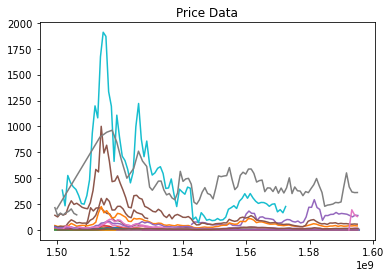

In [196]:
i =0
for cryp in crypto_prices:
    x = crypto_prices[cryp]['time'].values
    y = crypto_prices[cryp]['price'].values
    x = x[0::240]
    y = y[0::240]
    plt.plot(x,y,label=cryp)
    plt.title('Price Data')
    i+=1
plt.show()


In [11]:
print(df)

      Unnamed: 0       Source  \
13            13   Bitcoinist   
14            14   Bitcoinist   
16            16   Bitcoinist   
17            17   Bitcoinist   
18            18   Bitcoinist   
...          ...          ...   
9752        9752  CoinSpeaker   
9772        9772  CoinSpeaker   
9791        9791  CoinSpeaker   
9899        9899  CoinSpeaker   
9918        9918  CoinSpeaker   

                                                  Title  \
13      Ripple’s XRP Scores New Crypto Exchange Listing   
14    Bitcoin.com Fires 50% of Staff Ahead of BCH Ha...   
16    Ripple Launches X-Border App With Thai Commerc...   
17    Hijacked YouTube Accounts Promote Crypto Scam ...   
18    Telegram Project in Trouble as Investors Said ...   
...                                                 ...   
9752  Winklevoss Twins Switch To BATS Global Markets...   
9772  Lisk CEO Max Kordek Talks About Perspectives O...   
9791  Slock.it to Let Clients Anonymously Rent Any O...   
9899  Bank of

In [12]:

df['TimeStamp']=  df['TimeStamp'] -3600

Now we have the UTC adjusted Time for Articles and Price Data

# The Total Amount of Articles Collected Per Altcoin

In [13]:
df_art

,Coin,Symbol,Amount
0,Ripple,XRP,829
8,EOS,EOS,292
1,Bitcoin Cash,BCH,256
4,Litecoin,LTC,234
10,Stellar,XLM,199
3,Cardano,ADA,197
27,Dogecoin,DOGE,155
11,TRON,TRX,145
12,Monero,XMR,119
7,Binance Coin,BNB,113


# PreProcessing

In [14]:
porter = PorterStemmer()
lancaster=LancasterStemmer()
stop=list(set(stopwords.words('english')))
token_new=[]
texts_new=[]

#preprocess the texts of the data within CountVectorize
def mypreprocess(text):
    #text is a document of a corpus
    #lowercase of text
    text=text.lower()
    #remove all the irrelevant numbers and punctuation
    text=re.sub(r'[^a-z]+',' ',text)
    #tokenize the words
    token1=word_tokenize(text)
    #remove the meaningless stopping words
    token2=[t for t in token1 if t not in stopwords.words('english')]
    #stemming transformation
    Porter=1
    if Porter==1:
        token3=[porter.stem(t) for t in token2]
    else:
        token3=[lancaster.stem(t) for t in token2]
    return token3


def isUsable(x):
    res = [ele for ele in df_art['Symbol'].values if(ele in x)] 
    if len(res) == 1:
        return res
    elif len(res) > 1:
        return False
    else:
        res = [ele for ele in df_art['Coin'].values if(ele in x)]
        if len(res)==1:
            res = df_art['Symbol'].loc[df_art['Coin'] == res[0]].values
            return res
        else:
            return False 

# From StackOverFlow
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
        
    #val = [isIncluded(t) for t in x]
    #print(val)

In [15]:
#TimeFrame in Hours

TimeFrame = 24 * 3600

#for x in tqdm(df.iterrows()):
def process(x):
    try:
        usable = isUsable(x[1][2])
        if usable != False:
            timestamp = x[1][4]
            est = find_nearest(crypto_prices[usable[0]]['time'].values,timestamp)
            if 3600 > abs(timestamp-est):
                first = crypto_prices[usable[0]]['price'].loc[crypto_prices[usable[0]]['time'] == est].values
                second = crypto_prices[usable[0]]['price'].loc[crypto_prices[usable[0]]['time'] == est+TimeFrame].values
                returns = first/second -1
                x = x[1]
                text = x[5]
                print(returns[0])
                token_new.append(mypreprocess(text))
                texts_new.append(' '.join(mypreprocess(text)))
                return [usable,x[1],x[2],x[3],est,est+TimeFrame,returns[0]]
    except:
        i=0
data_processed = [process(x) for x in tqdm(df.iterrows())]
  

0it [00:00, ?it/s]

-0.018270401948842885


1it [00:00,  6.93it/s]

0.005007153075822668


3it [00:00,  7.77it/s]

-0.005420054200541813


7it [00:00, 10.04it/s]

-0.07009995366386446


9it [00:00, 10.95it/s]

-0.07845934379457908


11it [00:00, 11.73it/s]

-0.1455550437586366


15it [00:00, 13.34it/s]

-0.13118617439120184
0.12824675324675328


19it [00:01, 14.24it/s]

0.017448856799037404
0.10867237687366171


23it [00:01, 14.69it/s]

0.02061219451987162
-0.016730401529636674


27it [00:01, 14.60it/s]

-0.0836052202283849
0.014604810996563522


31it [00:02, 14.27it/s]

-0.07040913415794481
0.01887979861548139


33it [00:02, 11.11it/s]

-0.03178276269185354
0.014794267221451607


38it [00:02, 11.48it/s]

0.020716685330347095


40it [00:02, 11.72it/s]

-0.0005571030640667551
0.005211047420531578


50it [00:03, 17.09it/s]

0.02331674089599156
0.02136752136752129


58it [00:03, 21.86it/s]

0.01635991820040905
-0.0490921318090114


61it [00:03, 16.77it/s]

-0.0217696629213483
0.007373271889400845


64it [00:03, 15.51it/s]

-0.009926189870196
0.012558869701726927


68it [00:04, 12.47it/s]

0.004514672686230181
-0.017311021350259637


70it [00:04, 13.04it/s]

-0.04868316041500398
0.017376194613379692


74it [00:04, 11.69it/s]

0.0076832151300236795
-0.04635761589403964


78it [00:05, 13.14it/s]

0.029739776951672736
0.027535037098103787


82it [00:05, 12.11it/s]

0.002423654871546388
0.029126213592232997


87it [00:05, 13.65it/s]

-0.027405991077119163
-0.11962338949454909


91it [00:06, 13.38it/s]

-0.034372785258681815
0.040459770114942506


93it [00:06, 10.51it/s]

-0.1464747294315435
0.053216838760921314


95it [00:06, 11.50it/s]

-0.04264392324093813
-0.0020374143359881414


100it [00:06, 12.73it/s]

0.10587475790832812
-0.0016843225034351983


102it [00:07, 10.59it/s]

-0.012789281364190108
-0.04843820733363524


106it [00:07, 11.95it/s]

-0.142135642135642
-0.014873140857392775


121it [00:07, 20.45it/s]

0.018646408839779083
0.012573964497041512


132it [00:07, 26.72it/s]

-0.05163466528282312
0.014253897550111416


143it [00:08, 29.78it/s]

-0.030492231740961384
0.001103617412630209


149it [00:08, 34.17it/s]

0.04647676161919034
-0.07373370378285948


154it [00:08, 29.55it/s]

-0.06313645621181263
-0.004287114159725713


159it [00:08, 22.83it/s]

-0.030540720961281576
-0.02618328298086614


167it [00:09, 27.48it/s]

-0.03758099352051825
0.24421388667198718


171it [00:09, 28.70it/s]

0.020497311827956777
0.024780252859723184


175it [00:09, 20.69it/s]

0.001704303365999138
0.04093919325707396


181it [00:09, 23.13it/s]

-0.0078125
-0.05043526323062053


191it [00:09, 29.54it/s]

0.023426642842962142
-0.005847953216374324


196it [00:10, 27.16it/s]

0.035116153430577945
0.03375188347564029


204it [00:10, 22.71it/s]

-0.00615238996687173
0.004381161007666945
0.02324478178368139


215it [00:10, 28.89it/s]

0.0
0.16563728242560383


219it [00:10, 24.63it/s]

0.007104194857916024
0.030968293441093975


232it [00:11, 33.08it/s]

0.005300353356890497
0.06637453280061845


237it [00:11, 27.83it/s]

-0.006528526823729841
-0.010216110019646285
0.02752704214845214


246it [00:11, 33.19it/s]

0.07669491525423733
-0.05189038315148431


251it [00:11, 22.64it/s]

-0.0007867820613689513
0.004482477587611999


269it [00:12, 30.95it/s]

0.0077776361086319135
0.06588669950738923


275it [00:12, 25.53it/s]

0.015522771007055791
0.020584602717167666
0.06699586280528491


280it [00:12, 24.80it/s]

-0.078125
-0.08494558645707362


284it [00:13, 21.83it/s]

-0.06170483460559806
0.013343217197924417


295it [00:13, 27.90it/s]

0.1516743269862113
0.06258036862408911


301it [00:13, 31.42it/s]

0.06353749284487686
0.27095877721167216


305it [00:13, 21.52it/s]

0.02682926829268295
-0.00877032706011327


314it [00:14, 21.67it/s]

-0.01349948078920038
-0.17118307997356252


317it [00:14, 17.37it/s]

-0.17892768079800492
-0.013305110371938378


324it [00:14, 21.39it/s]

-0.11199364575059567
0.003552397868561208


337it [00:15, 27.04it/s]

-0.006497486821135268
-0.012645914396887115
-0.052602436323366475


341it [00:15, 24.81it/s]

0.014388489208633004
-0.028843203436636933


348it [00:15, 20.54it/s]

0.0059752454118651155
0.008525149190110826
-0.05620805369127513


359it [00:15, 25.17it/s]

-0.24424778761061938
0.04724061810154523
0.016999575010624657


363it [00:16, 23.00it/s]

0.008319467554076532
-0.14756517461878993


369it [00:16, 25.06it/s]

0.015396458814472602
0.050233225690706984
-0.022227772227772058


375it [00:16, 21.28it/s]

0.031146891909726637
0.03268892794376099


381it [00:16, 23.34it/s]

0.032937365010799136
-0.08837209302325577


394it [00:17, 30.78it/s]

-0.038456120580363296
-0.23282571912013528


407it [00:17, 38.50it/s]

0.41392203659506754
0.4167330677290837


412it [00:17, 27.37it/s]

0.13531775824758197
0.01582969432314396


416it [00:17, 24.25it/s]

0.0016375545851530227
0.052053354688555764


436it [00:18, 31.82it/s]

-0.03994044536509578
-0.0062028047464941505
0.0027677830058123742


449it [00:18, 42.02it/s]

0.006979194100605879
0.06973249173429519


455it [00:18, 36.13it/s]

-0.14841108857336038
-0.01623635879691243


464it [00:18, 42.69it/s]

-0.01292059219380881
-0.007938841517200701
-0.04060547813551185


470it [00:19, 28.10it/s]

-0.03228021978021978
-0.0037647058823528923


480it [00:19, 31.77it/s]

0.015858423350953776
-0.04327485380116969


484it [00:19, 23.73it/s]

-0.11656910155255795
0.08181370133070476
-0.005851901868107134


488it [00:20, 13.75it/s]

-0.1865519583427665
0.00865051903114189


491it [00:20, 15.86it/s]

-0.04363001745200701
-0.17711726384364823
0.03940779446984566


494it [00:20, 14.09it/s]

0.04029008863819494
-0.0691024622716443


502it [00:21, 13.40it/s]

-0.1328296368510845
0.0008401596303297953
-0.006948677313178164


516it [00:21, 17.98it/s]

-0.026606053355664572
-0.042051282051281946
0.00957374059721916


519it [00:21, 19.36it/s]

-0.005953095369547912
-0.0042918454935622075
0.02309554851927742


534it [00:22, 20.06it/s]

0.22821100917431192
0.1476664116296862


551it [00:22, 27.85it/s]

-0.023485289833964473
-0.01718671783747705
-0.0008833922261485272


557it [00:22, 24.74it/s]

-0.026907155529272586
-0.0429271103428408
0.057819905213270184


579it [00:23, 37.82it/s]

-0.013882018303240207
0.049165539016689186


604it [00:23, 55.38it/s]

0.036059806508355274
-0.08079526226734346


614it [00:23, 50.94it/s]

-0.10964912280701755
-0.11109526525955515
-0.09252217997465151


629it [00:23, 53.01it/s]

-0.006635361371988502
-0.0012970168612190802


638it [00:23, 57.27it/s]

-0.013686402856292745
0.0013705670721262386


657it [00:24, 53.27it/s]

0.024354061070589683
0.05428134556574915


689it [00:24, 51.01it/s]

0.07061847875396965
0.019461934745277798


722it [00:25, 67.73it/s]

-0.04671163575042159
0.023801428085685084
0.43446153846153845
0.04304296853192402


745it [00:25, 54.46it/s]

0.08702531645569622
0.05851791085589264
0.21273291925465831


754it [00:26, 23.59it/s]

0.08883405305367065
0.014528955954322909


761it [00:27, 15.12it/s]

0.015270935960591148
0.0421994884910486


771it [00:27, 22.92it/s]

0.025827280064568248
-0.049079754601227044
-0.06812339331619544
-0.03347280334728031


776it [00:27, 17.64it/s]

-0.03567035670356711


785it [00:28, 21.34it/s]

-0.04743339831059146
0.03457008990755983


796it [00:28, 29.08it/s]

-0.01768219832735951
0.04301075268817223


801it [00:28, 27.19it/s]

-0.07293035479632048
-0.12124542124542126


830it [00:29, 38.85it/s]

-0.04748858447488569
0.03515944399018811
0.07940127922826878
0.12359550561797761
0.014376620315814215


836it [00:29, 23.21it/s]

-0.055404178019981765
0.018902071184395686


848it [00:29, 27.73it/s]

-0.055243445692883864
-0.008799374266718729


853it [00:30, 30.44it/s]

0.005297233666862855
0.034782608695652195


867it [00:30, 31.12it/s]

0.0004469273743017421
0.008040739748056858


872it [00:30, 28.10it/s]

-0.0188904354742494
-0.016822051074179223


876it [00:30, 23.88it/s]

-0.03203342618384397
-0.136067101584343


880it [00:31, 21.42it/s]

0.007042253521126751
-0.0787637088733798


889it [00:31, 24.89it/s]

-0.038058584562753905
0.03733333333333322


902it [00:31, 34.31it/s]

-0.057249322493224786
-0.07036247334754797


907it [00:31, 35.41it/s]

0.08710138029509751
0.00547045951859948


923it [00:32, 30.01it/s]

0.007198560287942302
0.07226264596304355


949it [00:32, 40.56it/s]

0.055782898987723595
0.18203957382039593


974it [00:32, 46.90it/s]

0.08315166614761749
-0.07698590974065767


1008it [00:33, 69.27it/s]

-0.09116192830655123
0.09462824617573795


1020it [00:33, 74.59it/s]

-0.02905027932960902
-0.040603248259860836


1051it [00:33, 71.34it/s]

0.10068119891008176
-0.013966956225515248


1073it [00:33, 76.28it/s]

0.0006624710168932069
-0.001077005923532548


1083it [00:34, 55.15it/s]

-0.061486864169927435
0.001640958319658603
0.00014797277300981904
-0.014113420579933256


1091it [00:35, 21.52it/s]

-0.07149091486154091
-0.01770164168451105


1108it [00:35, 27.67it/s]

0.040271877655055244
0.06784729959537916


1120it [00:35, 29.57it/s]

0.01680825797022023
0.005391275935304529


1127it [00:36, 35.38it/s]

-0.004693261816962835
0.019705277587388492


1144it [00:36, 38.00it/s]

-0.07288801571709247
-0.03133732534930145
0.08473666954785242


1190it [00:36, 58.45it/s]

-0.15299837925445714
-0.07305034550839096


1202it [00:37, 56.06it/s]

-0.0712203248646397
-0.01821903787103374


1212it [00:37, 51.35it/s]

0.35843793584379346
0.0047784535186794486


1220it [00:37, 45.60it/s]

-0.11955922865013768
0.04681100058513765
-0.0020384078961485086


1233it [00:37, 43.78it/s]

0.028133577310155644
-0.14522913438122642
-0.040780704538241896


1252it [00:38, 50.42it/s]

-0.08997066174073665
-0.0762913907284768


1258it [00:38, 31.27it/s]

-0.0375798264286884
-0.02896904288554414
-0.023407729994556314


1283it [00:38, 38.54it/s]

0.04175695949324876
0.01900374316153175


1307it [00:39, 54.53it/s]

-0.02821224352505891
-0.005979705242812328


1334it [00:39, 70.16it/s]

-0.04025191675794093
0.09731729513710285


1346it [00:39, 48.20it/s]

0.1924135056273446
0.09506205439662008
0.006673021925643674
-0.00928414365990704


1364it [00:40, 44.73it/s]

-0.008157715839564816
0.020273972602739887


1372it [00:40, 48.91it/s]

0.006040992448759441
0.0


1388it [00:40, 47.31it/s]

-0.07918717088246596
-0.12443158329888393
-0.12052890320393295


1434it [00:41, 60.51it/s]

0.2463550600343054
0.07034696554191
0.03465691396725856
-0.06648451730418947


1457it [00:41, 52.35it/s]

0.11442705812765497
-0.07419035029742227


1477it [00:41, 63.41it/s]

0.06907671418873051
0.059822150363783244
0.032671629445823136
0.0902917966599377


1486it [00:42, 39.08it/s]

0.01198083067092659
0.030131004366812153
-0.0488375547797667


1493it [00:42, 27.94it/s]

-0.02299459459459452
0.00905373831775691


1499it [00:43, 29.01it/s]

-0.09081606548989518
0.012542929670001701


1508it [00:43, 27.19it/s]

-0.062259207890275836
0.019162526614620257


1518it [00:43, 31.56it/s]

0.0022203895197614454
0.0735383678440924


1545it [00:43, 48.11it/s]

-0.02676594888307493
-0.061384941034169804


1553it [00:44, 42.34it/s]

0.02674871279668478
-0.006126914660831484


1560it [00:44, 41.08it/s]

0.0199151997944238
0.06335694327116781


1566it [00:44, 28.90it/s]

0.03217358772914336
-0.2627233438689286


1575it [00:44, 30.17it/s]

-0.22115449685321786
-0.0057848655409631355


1583it [00:45, 29.35it/s]

-0.004901960784313597
-0.03228732087792496


1614it [00:45, 46.20it/s]

-0.06449771689497719
-0.21501272264631044


1622it [00:45, 39.71it/s]

0.062047346232839695
0.22956841138659323
0.21545514079895223
0.07644855695087038


1629it [00:46, 17.54it/s]

0.1692978499473763
0.17317824833482454


1648it [00:46, 27.26it/s]

0.04251445705718582
0.06958704083960732


1672it [00:47, 39.55it/s]

0.3107922776664205
0.2919823232323231


1682it [00:47, 47.02it/s]

0.01976823449216103
-0.14973262032085555


1697it [00:47, 54.59it/s]

0.12363387978142071
0.16591639871382657


1711it [00:47, 53.03it/s]

-0.09472606246799797
0.18789653489507097


1717it [00:48, 53.11it/s]

0.20769094453304993
-0.0016920473773265332


1723it [00:48, 32.96it/s]

-0.06334563345633437
-0.027792529651265552


1728it [00:48, 23.82it/s]

-0.1986928104575164
-0.13578336020847093


1737it [00:49, 26.26it/s]

-0.018492876562348992
-0.11134127395132054


1748it [00:49, 33.36it/s]

0.07130477841049765
0.17672818267125434


1758it [00:49, 36.26it/s]

-0.2834409080792344
-0.04585987261146496


1762it [00:49, 34.62it/s]

0.03915662650602414
-0.032695593009754664


1770it [00:50, 26.85it/s]

-0.12665337186113712
0.024970963995354145


1784it [00:50, 37.02it/s]

-0.07890966707464009
0.08894379246448403


1796it [00:50, 38.05it/s]

-0.012144129731301967
-0.2435344018617921


1806it [00:50, 32.09it/s]

0.006315278115132328
0.00038617493724668606


1810it [00:51, 30.72it/s]

-0.06442080378250592
0.21216633643870675
0.4513439635535308


1821it [00:51, 25.74it/s]

0.163108242303873
-0.042966450853443305


1843it [00:51, 35.02it/s]

-0.03593642017968224
0.05020445252158123


1852it [00:51, 32.49it/s]

-0.01729106628242072
1.0474723428091304


1860it [00:52, 35.06it/s]

0.028762541806020003
-0.04504730280057656


2373it [00:52, 56.40it/s]

0.07221880762138921
-0.02708803611738142
0.01399271612037567
-0.0003636363636364548
-0.020527859237536528
-0.015721504772599593


2480it [00:53, 63.72it/s]

0.03885972047622577
0.005696279238880164
-0.043170320404721796
-0.0013470487386725294
0.0013151239251392166


2558it [00:54, 72.03it/s]

0.020007987220447276
0.025602409638554313
-0.012156188605108031
-0.08073522568636582
0.05229978018331871
-0.07988121193895181


2616it [00:55, 61.19it/s]

-0.00217548948513413
-0.009345794392523255
0.0729709605361133
-0.013727810650887462


2689it [00:56, 79.32it/s]

0.034024896265560045
-0.0193133047210301


2717it [00:56, 95.09it/s]

-0.001804821451592109
0.11490250696378834


2742it [00:57, 88.95it/s]

-0.06440976038689827
0.010294177483012534


2762it [00:57, 81.10it/s]

-0.03551074090311268
-0.0401920682909479
-0.028125000000000067
-0.023353876094712955


2790it [00:58, 53.49it/s]

-0.03725961538461531
0.02198852772466542


2809it [00:59, 38.23it/s]

0.020493712156497423
-0.12543825477210735


2824it [00:59, 41.52it/s]

-0.04908779804893215
0.040441176470588314


2832it [00:59, 43.11it/s]

0.010126582278481067


2838it [01:00, 16.00it/s]

0.031761308950914335
-0.04335919671382915


2854it [01:00, 22.63it/s]

-0.002991675338189448
-0.010607762386122599


2904it [01:01, 39.35it/s]

-0.10699999999999998
0.054587688734030415
0.12442999683958633
-0.06923770861524581
0.054587688734030415


2914it [01:01, 29.45it/s]

0.12442999683958633
-0.06923770861524581


2928it [01:02, 37.08it/s]

0.013692643845593544
0.01962110960757779


2972it [01:02, 50.11it/s]

-0.02542113323124051


2985it [01:02, 41.58it/s]

-0.07199724006156782
0.010810659029006242


2995it [01:02, 38.67it/s]

0.20881971465629068
-0.0005250721974272565


3024it [01:03, 50.66it/s]

-0.0013118194936376781
0.006952965235173858


3057it [01:03, 64.16it/s]

0.06042741341193825
-0.047156726768377344


3074it [01:03, 58.20it/s]

-0.03424657534246578
0.04106226288774817


3138it [01:04, 90.16it/s]

0.011481918660800616
-0.0006362132586843483


3175it [01:04, 99.32it/s]

0.05481481481481487
-0.03150468312857302
-0.0016843225034351983
-0.05016893621378116


3198it [01:05, 56.68it/s]

0.0009447331128955572
0.08669001751313488


3214it [01:05, 43.15it/s]

0.01262502049516323
0.024496461622210086


3227it [01:06, 41.06it/s]

0.010593220338983134
0.014912280701754321


3233it [01:06, 38.81it/s]

0.026371703537057867


3253it [01:06, 45.83it/s]

0.04263038548752829
-0.1476909007773204


3271it [01:07, 27.17it/s]

-0.007719642200710752
0.01291128696376509


3282it [01:07, 28.63it/s]

0.020970394736842257
-0.039782016348773985


3293it [01:08, 29.97it/s]

-0.002331002331002363


3330it [01:08, 38.60it/s]

0.0006195019204557894
-0.06019656019656017


3366it [01:08, 57.85it/s]

0.020178905762429755
0.021632937892533066


3382it [01:08, 65.62it/s]

-0.0060831746212229865
-0.15056022408963587


3407it [01:09, 57.95it/s]

-0.01765267175572527
-0.023820430600091536


3456it [01:09, 76.45it/s]

0.0034990347490346796


3471it [01:09, 60.57it/s]

0.07685664939550962
0.017097640243040946


3483it [01:10, 52.23it/s]

0.010509296685529579
0.05121591746499643


3493it [01:10, 46.04it/s]

0.018737820416729223


3517it [01:11, 45.94it/s]

0.012135355892648692
-0.01847023831381034


3524it [01:11, 44.67it/s]

0.0056381957773512514


3536it [01:11, 36.11it/s]

-0.020928462709284612
0.06343792633015011


3551it [01:11, 44.32it/s]

0.02206177296430023


3587it [01:12, 50.03it/s]

0.07960860111137968
-0.040551500405514807


3596it [01:12, 52.21it/s]

-0.03867859600825874
-0.01941747572815522


3615it [01:12, 44.88it/s]

0.06273126236984772
0.015378389316066388


3629it [01:13, 43.26it/s]

0.035815734222551576
-0.1621472053126729


3665it [01:13, 56.64it/s]

0.012971946846656923
-0.01244239631336408


3689it [01:13, 62.40it/s]

-0.02688455455983141
0.018277571251549052


3709it [01:14, 73.66it/s]

0.010340865568747581
-0.06635622817229325


3719it [01:14, 42.53it/s]

-0.07080673244341273
-0.1473467284904687


3727it [01:14, 34.47it/s]

0.15564738292011016
0.03198716739007357


3757it [01:15, 45.54it/s]

0.04357999415033653
0.03503733486502014


3767it [01:15, 39.99it/s]

0.019860973187686204
0.05772624149231187


3775it [01:15, 32.66it/s]

-0.22277597807126837
-0.0030314513073133043


3782it [01:16, 23.38it/s]

-0.05813953488372081
-0.08519692168401993


3802it [01:16, 32.67it/s]

0.001214697843911372
0.10252944583896517


3850it [01:16, 53.23it/s]

-0.09226190476190466
0.34793554884189315


3872it [01:17, 55.82it/s]

0.10566356720202874


3900it [01:18, 28.71it/s]

-0.05470263824713084
-0.11041292639138245


3916it [01:18, 36.77it/s]

-0.10234374999999996
-0.02299065420560742


3963it [01:19, 51.31it/s]

0.013415315818893214
0.03971593897948433


3989it [01:19, 64.40it/s]

0.11219879518072284
-0.04490690032858713


4003it [01:19, 47.89it/s]

0.14482378854625555
-0.020731163620151594


4014it [01:19, 50.60it/s]

0.051520794537554426
-0.058496441281138845


4023it [01:20, 39.91it/s]

0.01249705258193834
-0.009449028480170374


4030it [01:20, 30.84it/s]

0.013740102468560833
0.024788732394366297


4043it [01:21, 28.28it/s]

-0.06683937823834207
-0.008143322475570036


4065it [01:21, 39.07it/s]

0.010526315789473717
-0.1282051282051282


4090it [01:21, 47.14it/s]

-0.22530120481927718
0.0041024190125902305


4097it [01:22, 34.17it/s]

0.009061378013335508
-0.016361416361416303


4103it [01:22, 34.53it/s]

-0.06597549481621123


4108it [01:22, 30.11it/s]

-0.008608971454463155


4134it [01:23, 33.81it/s]

-0.09493670886075944
0.01334127456819556


4150it [01:23, 39.68it/s]

0.0
-0.00874565712231945


4161it [01:23, 37.28it/s]

-0.005080440304826461
-0.08567774936061379


4188it [01:24, 50.34it/s]

0.007891414141413922
-0.09337646990449266


4201it [01:24, 44.45it/s]

0.023333333333333428
0.025423728813559254


4264it [01:24, 68.86it/s]

-0.03301295445048069
-0.16086956521739137


4302it [01:25, 84.68it/s]

-0.027554048325561742
0.022336769759450315


4315it [01:25, 60.54it/s]

0.022336769759450315
0.0018394429115753397


4348it [01:25, 72.71it/s]

0.005275974025974017
-0.019299591002045036


4358it [01:26, 53.12it/s]

-0.020584292257848302
0.02667066227150139


4379it [01:26, 58.43it/s]

0.00201918223119657
0.11309523809523836


4419it [01:26, 79.24it/s]

-0.11985018726591767
0.036340852130325674


4429it [01:26, 68.38it/s]

-0.01432078559738137
0.015631601182932053


4445it [01:27, 49.55it/s]

0.018135807676086024
0.13208762886597936


4498it [01:27, 64.48it/s]

-0.035683202785030566
-0.016949152542372947


4519it [01:28, 65.49it/s]

-0.004903809883063048
0.03586103847590594


4531it [01:28, 58.56it/s]

-0.003125814014066197


4546it [01:28, 47.82it/s]

0.05810301507537674


4553it [01:29, 40.77it/s]

-0.05124056094929885


4563it [01:29, 34.18it/s]

-0.012027060886995677


4584it [01:29, 38.61it/s]

0.00028901734104036514
0.043511305339160256


4597it [01:30, 41.19it/s]

0.0
0.03490358799121318


4621it [01:30, 52.59it/s]

0.07296137339055786


4629it [01:30, 34.21it/s]

0.0170815031722793
0.020822752666328048


4666it [01:31, 52.63it/s]

0.03444263439609019
-0.07658157602663707


4690it [01:31, 63.05it/s]

0.27073459715639814
-0.08304630692690385


4708it [01:32, 46.09it/s]

-0.021442986881937576
0.06382454411039928


4715it [01:32, 31.71it/s]

0.04838148277062282


4741it [01:32, 41.14it/s]

0.14856131712571163
0.2467347423414865


4822it [01:33, 63.24it/s]

0.10290371879775861
-0.017848264037719663


4848it [01:33, 69.65it/s]

-0.0285369072033832
-0.004958456177968307


4875it [01:34, 55.03it/s]

-0.04652233993551358
-0.04523682810005325
-0.055112400290065255


4893it [01:34, 32.24it/s]

-0.0346308724832215
0.007132915796798978


4908it [01:35, 39.07it/s]

0.027228432215534504
-0.14617618586640846


4924it [01:35, 39.74it/s]

0.0031028628300451278


4945it [01:36, 42.74it/s]

0.05399497212810167
-0.05745341614906829


4958it [01:36, 46.96it/s]

-0.030845771144278777


4970it [01:36, 35.21it/s]

0.02628434886499398
0.07424315233061018


4975it [01:37, 29.55it/s]

0.07424315233061018


4982it [01:37, 30.24it/s]

-0.01788617886178867
-0.01788617886178867


4994it [01:38, 15.61it/s]

0.01605136436597121
0.09695130761450654


5012it [01:38, 20.11it/s]

-0.011831819142193112


5027it [01:38, 23.86it/s]

-0.008635578583765069
0.10129460056836126


5073it [01:39, 30.45it/s]

-0.12185534591194969


5087it [01:39, 35.23it/s]

-0.2810214741729542


5093it [01:40, 27.98it/s]

-0.007655502392344471


5098it [01:40, 24.45it/s]

-0.0970404984423675


5102it [01:40, 17.49it/s]

0.034754377561339034


5107it [01:41, 17.30it/s]

0.05835500650195069


5113it [01:41, 17.47it/s]

-0.034987794955248286


5147it [01:42, 24.58it/s]

0.0001605136436597654
-0.09403254972875219


5177it [01:42, 31.40it/s]

0.18845618915159923


5189it [01:42, 34.30it/s]

0.020899053627760233


5203it [01:43, 34.63it/s]

0.07278875244705474


5209it [01:43, 31.07it/s]

0.024286183130948436


5242it [01:43, 38.83it/s]

-0.05894681687188874


5251it [01:43, 37.57it/s]

0.42427049559981467


5264it [01:44, 40.49it/s]

0.18732525629077346


5270it [01:44, 27.47it/s]

0.03272418189545245


5275it [01:44, 23.87it/s]

0.20461853259280915


5284it [01:45, 24.29it/s]

0.1172559685705652


5288it [01:45, 18.01it/s]

0.09749739311783112


5293it [01:45, 16.57it/s]

0.09119373776908013


5297it [01:46, 14.37it/s]

-0.09053651266766016


5300it [01:46, 12.10it/s]

-0.2757352941176471


5302it [01:47,  9.01it/s]

-0.33812434474709707


5309it [01:47, 10.91it/s]

-0.04236111111111118


5314it [01:47, 11.71it/s]

-0.1433121019108281


5319it [01:47, 12.86it/s]

-0.14236589985472858


5330it [01:48, 15.16it/s]

-0.13220147142048666


5343it [01:48, 16.86it/s]

0.028533510285335018


5352it [01:49, 17.22it/s]

-0.10378877321026081


5355it [01:49, 11.50it/s]

0.0146520146520146
0.04484088717454204


5362it [01:50, 11.95it/s]

-0.014257939079714954


5370it [01:50, 12.99it/s]

-0.2104404567699838


5372it [01:51,  7.79it/s]

0.1520088192062714


5374it [01:51,  7.22it/s]

0.005674378000873004


5376it [01:52,  6.53it/s]

-0.4486527228189183


5377it [01:52,  4.36it/s]

-0.02126099706744855


5378it [01:52,  4.11it/s]

-0.14444444444444438


5386it [01:53,  6.65it/s]

0.02767682415431927


5597it [01:53,  9.48it/s]

-0.004320691310609859
-0.05308525176074841
-0.004314477468839839
-0.024853801169590573
0.017788824038649453
-0.0007533902561527306


5628it [01:54, 12.20it/s]

0.0078064012490242085
0.020752003287445975
-0.37769978401727855
-0.06964573268921093
0.056599890230515815
0.01291283161884138


5671it [01:55, 20.32it/s]

-0.14100750734414103
-0.014002897151134786


5687it [01:55, 26.31it/s]

-0.03293807641633728
-0.047863034241439784
-0.056011949215832635
-0.0076045627376425395


5721it [01:55, 41.39it/s]

0.02148760330578514
0.17861720067453613
0.007845188284518745


5734it [01:55, 49.36it/s]

0.0262570488721805


5762it [01:56, 63.08it/s]

0.003665689149560114
-0.0034196384953590897


5774it [01:56, 70.96it/s]

0.04361770365618978
0.07341507957213667


5786it [01:56, 53.10it/s]

0.028491030601477396
-0.09582659016232653


5813it [01:57, 55.89it/s]

0.015617128463476071
-0.0004957858205254517
-0.0581191753741882


5825it [01:57, 64.37it/s]

0.4988606380426961


5844it [01:57, 63.08it/s]

0.012951601908657295
-0.008086253369272267


5864it [01:58, 59.94it/s]

-0.07935630149864525


5879it [01:58, 56.47it/s]

-0.07935630149864525
0.028937577511368273
0.3728357510528777
0.0278597785977861
0.5434085510688837


5886it [01:59, 16.83it/s]

-0.02885437446565986
-0.11295238095238103


5895it [01:59, 19.92it/s]

-0.42805411658200476
-0.9999999911788292


5899it [01:59, 21.66it/s]

0.023498694516971286
0.02692640276710212


5908it [02:00, 24.63it/s]

0.0067069081153587895


5930it [02:00, 32.64it/s]

-0.003558718861210064
-0.05112637801565745


5952it [02:00, 43.03it/s]

0.016574585635359185
-0.07949253251967248


5963it [02:01, 35.70it/s]

-0.1267919719655941


6019it [02:01, 58.03it/s]

-0.006067610517191624
0.0025316455696202667


6043it [02:01, 74.02it/s]

0.0063131313131310485
-0.05750542299349237


6055it [02:01, 79.89it/s]

0.012584138132865075


6109it [02:02, 101.02it/s]

-0.01112906120983681
-0.025633762923098824


6122it [02:02, 91.37it/s] 

-0.034540859309182825
0.06339743589743585


6134it [02:02, 59.19it/s]

0.030807025470153127
-0.04364569961489084
0.0264402227134104
-0.01663585951940849


6164it [02:03, 49.90it/s]

-0.0036496350364962904
-0.009099181073703333


6173it [02:03, 50.79it/s]

-0.028693118134947238
-0.042922374429223864


6181it [02:03, 38.71it/s]

-0.1257978723404256
-0.012530120481927809


6207it [02:04, 49.59it/s]

-0.09060975609756072
-0.02322946175637386
-0.009004739336492928
0.0053859964093356805


6225it [02:04, 42.10it/s]

-0.09291763839450118
0.09150684931506836
-0.014481850667669605


6232it [02:05, 30.05it/s]

0.03508771929824572


6238it [02:05, 25.72it/s]

0.09242298084929224
0.004370523248755642


6248it [02:05, 27.30it/s]

0.1955278211128444


6270it [02:06, 35.63it/s]

0.0009259259259257746
0.0047990401919617565


6297it [02:06, 51.69it/s]

-0.01285102332222754
-0.0008527226215129247


6324it [02:06, 64.04it/s]

-0.13844870725604685
-0.013051584835301333
-0.04988437396762446


6362it [02:06, 80.72it/s]

-0.018649398704902898


6411it [02:07, 96.40it/s]

-0.1671159029649596
0.013751087902523995


6436it [02:07, 115.35it/s]

0.003147623544224043
-0.15010141987829606


6491it [02:07, 115.05it/s]

-0.03196859226023552
0.037217545414266695


6511it [02:07, 118.27it/s]

-0.027011494252873414
0.0743584941000186


6544it [02:08, 102.02it/s]

0.014844804318488336
-0.023728813559321882
-0.012756516916250682


6558it [02:08, 71.04it/s] 

-0.09271013656472415
-0.015885022692889605


6590it [02:08, 83.27it/s]

-0.12707306140744046
0.021369863013698698


6613it [02:09, 71.95it/s]

-0.02632753235162888
-0.014416775884665833


6631it [02:09, 83.53it/s]

-0.055118110236220486


6668it [02:09, 84.21it/s]

0.02085940759282434
-0.06820682068206829


6708it [02:09, 90.89it/s]

-0.07650073206442154
0.04716981132075482


6739it [02:10, 93.21it/s] 

0.0157945397269863
-0.013455657492354889
-0.015094843708255312


6761it [02:10, 57.90it/s]

-0.017543859649122973
0.16320117670655887
0.09538152610441775


6778it [02:11, 60.20it/s]

0.10825911611493866
-0.0420560747663552


6792it [02:11, 69.68it/s]

0.04148576941630466
0.004901960784313486


6818it [02:11, 71.99it/s]

0.01748251748251728


6832it [02:11, 67.43it/s]

-0.0020431055203909976


6852it [02:12, 47.77it/s]

-0.019089873005535662
-0.034599728629579385


6859it [02:12, 45.80it/s]

-0.043741588156123834
-0.2313341493268054


6871it [02:12, 41.76it/s]

-0.0027173913043477826
-0.02032235459004894


6902it [02:13, 53.02it/s]

0.010839269123567474
-0.021714285714285686
0.05157593123209181


6917it [02:13, 51.83it/s]

0.06216377764494885
0.08507042253521124


6987it [02:13, 97.92it/s]

0.008364312267657992
0.08941027266962598
-0.15219212510471936
-0.16285516285516288
0.6100917431192658


7021it [02:14, 82.74it/s]

-0.10801630434782605
-0.054782608695652324
-0.13654458598726127
-0.13692307692307681


7034it [02:14, 53.70it/s]

-0.30783817951959547


7044it [02:14, 47.26it/s]

-0.01803182086034172


7052it [02:15, 29.82it/s]

0.0066037735849058254
-0.08514335360556025


7059it [02:17, 10.64it/s]

-0.1594827586206896
-0.12647861692447682


7077it [02:17, 14.32it/s]

0.16860116069641795


7099it [02:17, 23.55it/s]

0.051130776794493515
-0.008107531470023632
0.02364574376612194


7175it [02:17, 32.97it/s]

-0.028833198598760656
-0.014432989690721598


7200it [02:18, 39.49it/s]

0.0243741765480896
0.0060975609756095395
-0.05327868852459017


7249it [02:18, 47.47it/s]

-0.02219815917704382
0.030982201713908974
-0.026400862068965414


7264it [02:18, 56.56it/s]

-0.037135278514588865
0.08596783139212438
0.10109763142692074


7277it [02:19, 51.53it/s]

0.09439638962015806
0.09896193771626294


7288it [02:19, 46.50it/s]

0.004416731618602121
0.03515996198923044


7329it [02:20, 54.73it/s]

-0.00025726781579626934
0.0


7378it [02:20, 78.44it/s]

0.034576534576534756
-0.0218678815489749
0.004832810867293702


7393it [02:20, 72.09it/s]

-0.0009124087591241281
-0.005684125050750999
-0.020150138285262686


7406it [02:20, 72.42it/s]

-0.018065034122842105
-0.06787833827893164
-0.09609708101016712


7449it [02:21, 82.20it/s]

-0.07819804504887373
0.0023169005019949562


7460it [02:21, 85.38it/s]

-0.006171953495048177


7507it [02:21, 109.23it/s]

-0.006425555351569745
-0.013370216689718828
-0.04507211538461553
-0.024677509814918674
-0.060500911962275916


7521it [02:22, 60.35it/s] 

0.0072342793544797335
0.004892885480031861


7577it [02:22, 86.95it/s]

0.014769261788945665
-0.0450928381962864


7641it [02:22, 119.64it/s]

-0.0011918951132300348
0.006582884500299091
-0.005226480836236891
0.04202311271199166


7660it [02:22, 124.26it/s]

0.000556792873051215
-0.04751958224543085
-0.022003284072249496


7699it [02:23, 104.15it/s]

-0.022331154684095966
0.07790549169859506
-0.004180274330502942
0.08524590163934431


7756it [02:23, 128.97it/s]

0.03212658834811788
-0.025163963667297895


7775it [02:23, 121.07it/s]

-0.003132341425215346
-0.008592631167816722


7791it [02:24, 63.78it/s] 

-0.0036477331943719493
0.006684491978609541


7831it [02:24, 67.36it/s]

0.03842298696959556
0.003273322422258529
0.019624573378839605


7875it [02:25, 93.79it/s]

-0.032498307379823954
0.0343219021232084
-0.20040383644623927
-0.004550773631517457


7889it [02:25, 58.52it/s]

0.10430686406460277
-0.06194251734390499
-0.030919703423252787


7900it [02:25, 51.64it/s]

-0.015151515151515138
-0.016365540717465432


7914it [02:26, 39.05it/s]

0.03441084462982258


7922it [02:26, 36.48it/s]

0.11987457790641565
0.004123546782303311


7953it [02:27, 49.40it/s]

-0.023679417122040025
0.06792452830188678
-0.002393776181927043


7968it [02:27, 57.97it/s]

-0.007320644216691097
-0.016855371689123433


7991it [02:27, 45.96it/s]

0.03691029088242481


8005it [02:28, 54.45it/s]

-0.017554125219426564
-0.01817569841804123


8058it [02:28, 78.43it/s]

-0.006286080821039097
-0.012048192771084376


8099it [02:28, 102.26it/s]

0.022168963451168366
0.13892215568862287
0.18453769519993424
-0.09242860305512512


8112it [02:29, 53.65it/s] 

0.014945289564985531
0.024960169941582677


8131it [02:29, 61.75it/s]

-0.017021732148592372
-0.0009380863039398779


8169it [02:29, 70.91it/s]

-0.08321775312066582
0.013688803873513011


8187it [02:30, 76.95it/s]

0.012352941176470456
0.005737428282146517
-0.0036900369003689537


8197it [02:30, 43.17it/s]

0.0571273122959739


8257it [02:31, 61.56it/s]

-0.1339634817598604
-0.005565068493150638
-0.15072958708475637


8292it [02:31, 72.59it/s]

-0.043486041517537544
-0.003972194637537396
-0.00351339481774271


8317it [02:31, 84.77it/s]

-0.05359722623519214
-0.014635463988409536


8370it [02:31, 104.61it/s]

-0.022912423625254585
-0.044520547945205435
0.11373801916932913
0.014519056261342866


8406it [02:32, 111.40it/s]

0.014228546020453647
0.019999999999999796


8441it [02:32, 122.92it/s]

0.014191717197781006
0.5821406347230866


8456it [02:32, 81.50it/s] 

0.01324965132496514
0.010415094339622621
-0.004121393780442073


8482it [02:33, 77.60it/s]

0.040856890459363804
-0.009208103130755041


8492it [02:33, 74.45it/s]

0.016744186046511622
0.024765478424014997
0.05656848994857411


8510it [02:33, 54.91it/s]

0.047641073080481044
0.009556481254594518
-0.09036301906502997
-0.06335514574657941


8566it [02:34, 71.95it/s]

-0.0019482819695358922
-0.02820569047749577
-0.004784688995215225


8575it [02:34, 75.43it/s]

0.035536411360882925
0.007788354555569477


8584it [02:34, 49.13it/s]

-0.001491795126802531
0.08241940844134277


8611it [02:35, 59.04it/s]

-0.009970918155380204
-0.006562500000000027
-0.1132075471698113


8627it [02:35, 41.33it/s]

-0.14532019704433485
-0.07163323782234965
-0.014788373278939226


8646it [02:35, 47.23it/s]

0.001221299462628167
0.09273570324574965


8665it [02:36, 54.79it/s]

0.07926267281105992
0.002827984753473567
-0.008819538670285065
0.0021394950791613354


8725it [02:36, 72.06it/s]

0.00773349196906592
-0.01363698349924991
0.0


8741it [02:37, 28.88it/s]

0.04191114836546528
0.00886699507389177
-0.08917197452229286


8750it [02:37, 34.10it/s]

-0.03825831702544025
-0.03688212927756651
-0.007589556769884598


8764it [02:38, 31.09it/s]

-0.041554599246906965
0.00030515715593537607
-0.03784295175023655


8782it [02:38, 41.35it/s]

0.01695057129703259
0.005109644453906936
0.010969285999202327


8791it [02:38, 37.66it/s]

-0.11468288444830566
-0.002339325289337668


8832it [02:39, 52.99it/s]

0.021844660194174637
0.005102040816326481
0.037061331584125945


8857it [02:39, 71.46it/s]

0.011260236578708005
0.16905989919118514
0.019645424053665428


8909it [02:39, 102.54it/s]

0.027569909413154736
0.008370702541106168
-0.02145922746781115
0.0023536635284486795


8925it [02:39, 98.19it/s] 

0.07792925571112752
0.00366300366300365
0.010202580075538314


8969it [02:40, 113.34it/s]

0.024920020205421833
-0.019512195121951237
-0.026193633952254602


9052it [02:40, 140.56it/s]

0.01785714285714257
-0.0019175455417066445
0.025453143077516227
0.0035058027079302168
0.014020618556701114


9131it [02:41, 86.79it/s] 

0.008603031544448969
0.021547900650502605
0.013749999999999929


9153it [02:41, 84.92it/s]

-0.0023809523809522615
-0.023539668700958916


9171it [02:42, 55.39it/s]

-0.023485321673953674
0.00840426678159667


9198it [02:42, 76.82it/s]

0.00976361767728684
0.0139211136890951
-0.01442337710991326


9216it [02:42, 81.42it/s]

-0.04344660194174765
-0.050000000000000044


9228it [02:43, 57.18it/s]

-0.04062038404726742
-0.005930318754633124
-0.005537974683544333


9291it [02:43, 74.22it/s]

0.022977022977022976
0.048099301784328974
-0.003362809814422607


9358it [02:43, 101.22it/s]

-0.04973869165615419
0.006244424620874156
-0.08142903121982625
0.01669302407309803
0.0004771751232701682
0.0011124845488257318
0.03226454920092481
0.008917197452229297
-0.08911982364981885
-0.05367016205910369
-0.10665646518745231
0.01795803066989521
-0.2196090894644842
0.030470914127423976
0.107727570399476
0.04529914529914514
0.0013393777045125344
0.07726672758655706
-0.20372786579683133


9387it [02:46, 27.18it/s] 

-0.34200413833875254
-0.1814742967992241
-0.13008493518104614
-0.10498297740637574
0.1078431372549018
-0.04080335579000893
0.14582749929991579
0.04531625300240183
-0.01461187214611881
0.025641025641025772
-0.038532110091743066
-0.014258131590672796
-0.0579634464751958
-0.004711962304301598
-0.004652605459056991
0.009724965810666841
-0.07331519129182018


9408it [02:49, 15.60it/s]

0.08082997832146188
-0.01932218984818279
0.009567265234029954
0.017142033995966477
0.03471196454948311
-0.019625892922895627
0.09075907590759069
-0.00021834061135372895


9423it [02:50, 13.96it/s]

-0.017764092846991986
0.004578313253011945
-0.04319371727748689
-0.002001334222815232
-0.08075893943079548
-0.01213130352045666
-0.006257110352673623
0.008022922636103269
0.019866415482103106
-0.05999008428358943


9434it [02:52, 10.64it/s]

0.059929494712103404
0.04133658943355778
-0.11564310544611822
-0.05848513902205155
-0.07020364415862812
-0.0387314790746035


9442it [02:53,  8.47it/s]

0.0032778924365668427
-0.023117338003502685
-0.00750670241286866
-0.02663024923181956


9448it [02:54,  8.93it/s]

-0.014145141451414545
-0.0325112107623321
-0.012141280353200834
0.001350894967916183


9457it [02:54, 10.56it/s]

-0.0984615384615386
0.01645979492714522


9460it [02:55, 10.64it/s]

-0.016480595427963762
0.012087912087912045


9466it [02:55, 14.13it/s]

-0.02049716528565204
0.01407549584133072


9469it [02:55, 16.15it/s]

0.031419939577039147
0.03739855231410383


9472it [02:56, 11.99it/s]

0.009108159392789306
-0.08245358572988704


9476it [02:56, 13.02it/s]

-0.03001876172607887
-0.07748600947051221


9478it [02:56,  9.65it/s]

-0.013990825688073416
-0.036435253569670034


9480it [02:56,  8.92it/s]

0.025286259541984712
-0.055584415584415625


9485it [02:57, 10.60it/s]

-0.07285078472710227
-0.1392117230924711


9487it [02:57,  7.79it/s]

0.017225747960109006
-0.058364634498699774


9493it [02:58,  9.68it/s]

-0.03615702479338845
-0.5920102385958498


9499it [02:58, 12.08it/s]

-0.3690825135514957
-0.07952548330404197


9501it [02:58, 10.23it/s]

0.004204204204204087
0.028021978021977922


9503it [02:59, 10.70it/s]

0.0


9507it [02:59, 10.26it/s]

0.027093596059113212
-0.09641873278236912


9511it [02:59, 11.27it/s]

0.0759280089988752
-0.02605281941470383


9513it [03:00,  9.53it/s]

0.020000000000000018
0.004217926186291798


9517it [03:00, 11.77it/s]

-0.012479201331114798


9519it [03:00,  8.51it/s]

0.015173410404624388
-0.07047387606318345


9521it [03:00,  9.37it/s]

0.015840220385674897


9523it [03:01,  7.97it/s]

0.004673363823370913


9527it [03:01,  9.35it/s]

0.03983445421624432
-0.01633865577422966


9531it [03:01, 10.09it/s]

0.028467908902691352
0.11154887958630866


9536it [03:02, 12.68it/s]

-0.027892089620484617
0.010629745422063408


9538it [03:02,  9.54it/s]

0.046511627906976605
0.0393013100436681


9540it [03:02,  9.05it/s]

0.16745967273993267
0.04331210191082824


9542it [03:03,  7.49it/s]

-0.11034761519805991
0.03581267217630835


9544it [03:03,  8.60it/s]

0.04651162790697683
-0.002680965147452974


9550it [03:03, 10.02it/s]

-0.02916073968705546
0.0034438226431339203


9554it [03:03, 11.16it/s]

0.005099675475197074


9561it [03:04, 12.65it/s]

0.1321260898725689
0.048828125


9567it [03:04, 15.25it/s]

-0.005610522639972082
-0.02527573529411753


9572it [03:05, 13.35it/s]

0.00426338228327805
-0.02174458476206398


9575it [03:05, 13.92it/s]

0.050130548302872
0.035728006146753755


9577it [03:05, 10.29it/s]

-0.04278874925194498


9579it [03:05,  9.05it/s]

0.04201982473782495


9587it [03:06,  9.76it/s]

-0.02523390983838958
0.10038022813688197


9589it [03:06,  8.84it/s]

0.014155052264808399
-0.0176711896497318


9591it [03:07,  6.02it/s]

-0.1557169930511687
-0.11671715259371451


9593it [03:07,  6.18it/s]

-0.02107558139534882


9595it [03:08,  5.52it/s]

-0.01448886503890523
-0.0427826086956522


9601it [03:08,  7.02it/s]

-0.13626834381551367
0.0037208366854384334


9605it [03:08,  9.45it/s]

0.021045836023240838
-0.028298279158699757


9615it [03:09, 13.78it/s]

-0.08781694495980219
0.007625649913344912


9619it [03:09, 16.29it/s]

-0.11943506294135708


9622it [03:09, 14.05it/s]

-0.08929149142672277
-0.0637037037037037


9635it [03:10, 17.42it/s]

-0.11695278969957079
-0.08603311735061192


9638it [03:10, 16.02it/s]

0.3252520403264523


9641it [03:10, 12.33it/s]

-0.019206145966709443
0.027158774373259087


9643it [03:11,  9.45it/s]

0.12272036474164127
-0.03811841038118413


9645it [03:11,  7.30it/s]

0.014760147601476037
-0.07880220646178104


9647it [03:11,  7.10it/s]

0.012998575498575526


9652it [03:12,  8.74it/s]

-0.01235677375870603


9654it [03:13,  4.24it/s]

0.014144545630691896


9661it [03:13,  6.40it/s]

-0.025289778714436273
-0.0077674768228515045


9663it [03:13,  7.56it/s]

-0.02607709750566889
-0.08481868469575915


9665it [03:13,  7.48it/s]

0.004430660168365019


9669it [03:14,  8.35it/s]

-0.026305139619587137


9671it [03:14,  8.06it/s]

-0.06579954093343543


9673it [03:14,  8.40it/s]

-0.002636203866432263


9675it [03:15,  8.66it/s]

-0.093993993993994


9678it [03:15,  7.83it/s]

0.06634721710283831
0.08267370272647323


9681it [03:15,  8.55it/s]

-0.06933115823817293
0.0010035122930256435


9688it [03:15, 11.92it/s]

-0.02862024775736871
-0.00804721030042932


9692it [03:16, 12.75it/s]

0.07037861915367483
0.03322304935208176


9696it [03:16, 13.78it/s]

0.015742522301906536
-0.01073558648111339


9710it [03:16, 18.37it/s]

0.06151035322777121
-0.02180579216354328
0.04088913282107565


9714it [03:17, 16.91it/s]

0.01650485436893212


9717it [03:17, 13.13it/s]

0.075744680851064
0.08372827804107419


9726it [03:17, 17.51it/s]

-0.0965834428383705
-0.0480732544830218
0.024851190476190332
-0.0051605504587156625


9733it [03:18, 15.36it/s]

-0.01369988966531821
0.02286482851378624


9736it [03:18, 14.21it/s]

0.051267916207276665
0.02968510554154924
-0.047131147540983576


9749it [03:18, 20.68it/s]

-0.06006006006006015
-0.0679665738161559
-0.018233705123736454
-0.13769192669638441
-0.07783182765809593


9753it [03:19, 16.52it/s]

0.007575757575757569
0.08142116950407119


9761it [03:19, 17.02it/s]

-0.008177386381506446
0.008875739644970349
0.05795262267343482
0.0337425315877109
-0.015086206896551602


9764it [03:19, 13.35it/s]

0.01521672302490007
-0.0007347538574576928


9769it [03:20, 14.09it/s]

0.06660666066606669
-0.13260869565217392


9773it [03:20, 15.25it/s]

-0.03234265734265729
-0.05684099660994635


9777it [03:20, 14.04it/s]

0.08431410380088766
0.04381654381654365


9781it [03:21, 15.99it/s]

-0.02120822622107965
-0.006528189910979143


9785it [03:21, 14.92it/s]

0.06731620903454383
-0.08417618270799354
0.016447368421052655


9790it [03:21, 16.66it/s]

0.0297283444387495
-0.009351927809680083


9794it [03:21, 13.25it/s]

0.06571428571428584
0.0641247833622185


9798it [03:22, 11.88it/s]

0.005510534846029147
-0.0629709364908505


9803it [03:22, 15.19it/s]

0.007599746675110763
0.002525252525252597


9810it [03:22, 18.74it/s]

-0.040857142857143036
-0.04409963250306248
0.06351942713168013
0.024272930648769453


9815it [03:23, 12.70it/s]

0.06976744186046502
-0.06916299559471362
0.02168021680216814
0.04596100278551529


9821it [03:23, 13.94it/s]

-0.1665247018739353
0.1265486725663718


9823it [03:23, 14.07it/s]

0.06154910096818811
-0.055404178019981765


9827it [03:24, 12.29it/s]

-0.013550135501355087
0.03846153846153855


9829it [03:24, 10.95it/s]

-0.15625
-0.04861111111111105
0.03268845897264838


9834it [03:24, 11.50it/s]

-0.11764705882352933
-0.06652360515021472
-0.11206896551724133


9836it [03:25,  9.06it/s]

-0.06903991370010776
0.06750000000000012


9838it [03:25,  9.08it/s]

0.1679946879150067
-0.013574660633484115


9840it [03:25,  7.76it/s]

0.03786191536748329
0.1320553780617677


9842it [03:26,  8.55it/s]

-0.030743432084963662
-0.09269356597600864


9843it [03:26,  8.24it/s]

-0.0011325028312568763
0.09325588899645054


9846it [03:26,  7.71it/s]

0.05607476635513997
0.08826628874595732


9849it [03:26,  9.22it/s]

0.07752956636005237
0.007566585956416461


9851it [03:27,  7.96it/s]

-0.12502045491736213
-0.013513513513513375


9853it [03:27,  8.38it/s]

0.06138009912314124
0.06292565266742334


9857it [03:27,  9.85it/s]

0.07302904564315349
0.13656387665198233


9861it [03:27, 11.68it/s]

0.050243111831442366
0.09751434034416828


9863it [03:28,  9.48it/s]

0.10366328916601719
-0.016049382716049276


9865it [03:28,  9.22it/s]

0.018564356435643692
0.0


9867it [03:28,  7.64it/s]

0.0378900445765229
-0.05968212779759996


9872it [03:29, 10.26it/s]

0.1896162528216705
-0.11073094867807165


9874it [03:29,  9.94it/s]

-0.054441260744985676
0.045323047251687676


9877it [03:29,  6.84it/s]

-0.03427719821162434
-0.15475950895552415


9881it [03:30,  6.60it/s]

-0.008416220351950998
-0.1084917617237009


9883it [03:30,  7.55it/s]

-0.07046010224494337


9885it [03:30,  6.65it/s]

-0.052475864216754875


9888it [03:31,  6.15it/s]

-0.10344827586206906
-0.06634033234574266


9891it [03:31,  7.03it/s]

-0.0227367023483529
0.0043290043290042934


9893it [03:32,  6.06it/s]

-0.09478467864098683


9895it [03:32,  6.22it/s]

0.05027887139107623
-0.242837653478854


9897it [03:32,  7.06it/s]

-0.029266681347720813
0.13602762966553583


9901it [03:33,  8.56it/s]

0.1610599078341013


9909it [03:33, 11.04it/s]

0.04657998869417734


9914it [03:33, 12.26it/s]

-0.003940239697914905
-0.05554133606347589


9918it [03:34,  9.12it/s]

-0.04698375870069593
-0.10848978844216506


9920it [03:34,  9.07it/s]

-0.22973464194838245
-0.059713375796178414


9922it [03:34,  8.15it/s]

-0.03475853583512767
-0.1401379310344828


9925it [03:35,  7.71it/s]

-0.10058139534883725
-0.46087411672337086


9928it [03:35,  7.38it/s]

-0.018081180811808206
-0.28127232716984363


9935it [03:35,  9.39it/s]

-0.036991368680641235
0.007778317938745838
-0.0034460124712832885


9953it [03:35, 13.05it/s]

0.005970149253731405
0.003106554830692776


9978it [03:36, 21.34it/s]

0.0073037127206330155
0.05003166561114614
-0.008363201911588902
0.055218271176640465


10008it [03:36, 36.58it/s]

-0.044472681067344366
0.03380230221085334
-0.033259423503326
0.05578055964653883


10030it [03:36, 54.00it/s]

0.0008017103153392657
0.011446886446886406
-0.025542784163473664
0.02667744543249806


10057it [03:36, 74.51it/s]

0.03380281690140863
0.05718824463860184
-0.058367999999999975
-0.00580130529369105


10119it [03:37, 112.05it/s]

0.057446030003659
0.008139104698483113
0.006506180871828304
-0.016219588271989993


10138it [03:37, 111.80it/s]

0.007895860008536149
0.01877682403433467
0.032488986784140916
0.0021706099413936197


10155it [03:37, 106.91it/s]

0.0791712104689204
0.12279355333844988
0.07149758454106281


10170it [03:37, 71.88it/s] 

-0.0037523452157598447
-0.019884541372674813
-0.09873060648801135
0.07533589251439543


10182it [03:38, 71.61it/s]

-0.03561749903213318
-0.028037383177569986


10192it [03:38, 54.29it/s]

0.010450685826257411
-0.0931796349663786
-0.05527331843121319


10254it [03:38, 78.61it/s]

-0.0471042471042471
-0.0561660561660563
-0.09243027888446209
0.05234526112185689


10273it [03:38, 62.67it/s]

-0.010955902492467695
-0.022681787858572444
0.006143344709897747
0.03409456416854284
0.031620553359683834
0.008797653958944274
0.006854009595613331


10314it [03:39, 74.04it/s]

0.054027743976636566
0.003603603603603567
0.025663716814159354
-0.013650885855358674


10356it [03:39, 98.23it/s]

0.04829210836277986
-0.010924796747967536
-0.0025657472738934706


10372it [03:39, 87.05it/s]

-0.004928536224741209
-0.01308494122865389
0.026774012357236643


10385it [03:40, 74.41it/s]

0.042896678966789725
0.04187489229708774
-0.02394427514148878
0.013368983957219305
-0.06741996233521652
0.025371828521434825


10396it [03:40, 43.35it/s]

-0.018224699828473412
-0.013137557959814528


10405it [03:41, 35.61it/s]

-0.04475084663763895
0.08137432188065108
0.004133298889175796


10412it [03:41, 38.73it/s]

0.04611872146118734


10433it [03:41, 56.07it/s]

0.008763388510223846
0.005003262997607338


10441it [03:41, 44.46it/s]

0.1681614349775784
0.016612377850163007


10448it [03:41, 46.98it/s]

0.056508999581414976
-0.021839276573963562
-0.0006148170919151319
-0.03510436432637565


10461it [03:42, 33.08it/s]

0.01902587519025878
0.023328149300155587


10466it [03:42, 25.04it/s]

0.07774914089347074
0.011619462599854913


10476it [03:42, 32.22it/s]

0.0013736263736263687
0.029572338489535888


10482it [03:43, 26.96it/s]

0.023421588594704668
-0.017078651685393242
-0.01623363544813694


10492it [03:43, 30.70it/s]

0.036796536796536605
0.01446280991735538


10498it [03:43, 34.82it/s]

0.01909273614699969
-0.052803929594760546


10510it [03:43, 33.02it/s]

0.007968127490039834
0.008866995073891548


10517it [03:43, 38.46it/s]

-0.03307810107197551


10531it [03:44, 36.47it/s]

-0.030127741624487836
0.07692307692307687


10572it [03:44, 57.64it/s]

0.04227687206410602
-0.025191055759977377
-0.03695408734602479


10581it [03:44, 59.25it/s]

-0.0417910447761195
-0.031764255644852635
-0.04253325838486033


10590it [03:45, 38.46it/s]

-0.042383292383292304
0.009270965023177258
0.005563985837126806


10601it [03:45, 43.69it/s]

0.044135188866799346
-0.027873595193056766


10615it [03:45, 41.40it/s]

0.010480349344978102
-0.010280373831775713
0.05500856164383561


10635it [03:46, 45.92it/s]

0.0036122817579771205
0.016072002571520416
0.01244444444444448


10641it [03:46, 40.61it/s]

0.22107792653621705


10646it [03:46, 21.04it/s]

0.14090019569471623
0.04264927245358763


10650it [03:46, 22.01it/s]

-0.08235638921453692
-0.01922590437642291


10663it [03:47, 24.34it/s]

-0.012944983818770184
-0.007063572149343944


10667it [03:47, 21.23it/s]

0.015044247787610487
-0.02812803103782746


10679it [03:47, 29.50it/s]

0.04927385892116187
-0.024654832347140054


10687it [03:48, 33.49it/s]

0.023295944779982758
0.03267700041893584


10698it [03:48, 36.94it/s]

0.03485576923076916
0.0034305317324185847
0.11120174007612826
0.01107174490699725


10703it [03:48, 19.22it/s]

0.034776520014004
-0.0005189413596261572


10710it [03:49, 19.24it/s]

-0.06484517304189441
0.015082427218519712


10720it [03:49, 24.32it/s]

0.019988577955453835
-0.014000848536274924


10724it [03:49, 19.83it/s]

0.09863013698630141
0.03486924034869232


10727it [03:50, 17.36it/s]

0.019523123699791922
0.07913978494623652


10732it [03:50, 13.26it/s]

0.036578805809575066
0.01835501858736066


10734it [03:50, 13.68it/s]

-0.01857142857142846
0.01037924151696612


10739it [03:51, 12.19it/s]

-0.02786531763144795
-0.028929097412160765


10743it [03:51, 14.67it/s]

-0.02328334648776642
-0.019816819317235557


10747it [03:51, 11.98it/s]

0.015433841520798186
0.043410041841004166


10751it [03:51, 12.60it/s]

-0.14125560538116588
0.08229988726042836


10755it [03:52, 12.28it/s]

-0.07180851063829796
0.03828623518687313


10759it [03:52, 12.62it/s]

0.006931836936788338
-0.01477832512315258


10763it [03:52, 12.66it/s]

-0.06305084745762712
0.024970737417089328


10768it [03:53, 13.47it/s]

-0.04332129963898923
-0.009277155005798288


10770it [03:53, 11.03it/s]

-0.054247697031729825
-0.0016642891107941926


10772it [03:53,  8.93it/s]

-0.035553555355535504
-0.025398570643210605


10776it [03:54, 10.85it/s]

-0.05057289608850246
-0.011251758087201025


10782it [03:54, 13.09it/s]

-0.018959257765228
0.016544117647058876


10784it [03:54, 10.64it/s]

0.13069401383257806
0.025337837837837718


10788it [03:55, 11.39it/s]

0.05100539480137334
0.03816793893129766


10792it [03:55, 12.34it/s]

-0.014008993427879535
-0.012912482065997155


10794it [03:55,  9.66it/s]

0.009646302250803762
-0.07321509777171442


10798it [03:55, 11.22it/s]

0.0063745019920318224
-0.01706596652445025


10803it [03:56, 12.73it/s]

0.035749950069902114
0.07897240723120835


10805it [03:56, 10.12it/s]

0.08922742110990223
0.1408888026392392


10809it [03:56, 11.19it/s]

0.05004591368227729
0.07318952234206466


10811it [03:57,  9.59it/s]

-0.043072824156305534
0.005584192439862523


10816it [03:57, 12.86it/s]

-0.04197638828159167
-0.05907172995780585


10818it [03:57, 10.28it/s]

0.013542107490478017
0.0007399186089531717


10824it [03:58, 12.52it/s]

0.02503498678277105
0.01768276590129325


10826it [03:58, 12.48it/s]

-0.005052935514918366
0.18380309646685178


10830it [03:58, 11.07it/s]

0.04225352112676073
0.01690821256038655


10832it [03:58,  9.29it/s]

0.2704174228675136
0.025771736052109695


10834it [03:59, 10.48it/s]

0.059326232350755514
0.02969348659003823


10838it [03:59, 10.63it/s]

-0.01624365482233514
0.0


10840it [03:59,  8.89it/s]

0.016489143793527283
-0.06543346217559354


10842it [03:59,  9.05it/s]

0.006931776723823502
0.011280931586608478


10844it [04:00,  9.78it/s]

0.0049586776859504855
-0.06871129460336178


10848it [04:00,  9.41it/s]

-0.041465766634522616
0.040985096328607584


10852it [04:00, 10.40it/s]

-0.05397625044980192
0.013829879476285445


10854it [04:01, 10.98it/s]

0.029902642559109793
0.10701009028146569


10858it [04:01, 10.11it/s]

-0.20191355988122728
0.051668092386655484


10860it [04:01, 10.55it/s]

-0.16719833269533413
-0.31512749827705033


10865it [04:02, 10.27it/s]

-0.03648548026805676
-0.09779579427413221


10867it [04:02,  9.98it/s]

-0.04251299008030218
-0.16847561963388946


10871it [04:02,  9.23it/s]

-0.07506297229219161
-0.0826893353941266


10873it [04:03,  8.16it/s]

-0.0131386861313868
0.02838550431953335


10876it [04:03,  9.66it/s]

-0.12862616310892172
-0.0012562814070351536


10880it [04:03,  9.93it/s]

-0.08608815426997252
-0.006464124111183023


10882it [04:04,  9.04it/s]

0.02206776715899239
0.011976047904191711


10884it [04:04,  8.43it/s]

-0.004306632213608941
0.0058798824023518215


10887it [04:04,  9.23it/s]

0.001875000000000071
-0.009704641350210985


10889it [04:04,  8.11it/s]

-0.0021558361564519846
-0.012505210504376807


10893it [04:05,  9.51it/s]

0.026794258373205926
-0.020453289110005657
0.00390930414386248


10897it [04:05, 10.73it/s]

-0.010533104041272612
-0.003866602223296267


10901it [04:05, 11.38it/s]

-0.03179364127174544
-0.000683060109289646


10903it [04:06, 11.49it/s]

-0.05498981670061098
-0.0017101325352714136


10907it [04:06, 10.03it/s]

-0.01098039215686275
-0.04067059919279736


10910it [04:06, 11.33it/s]

-0.006073752711496794
-0.10392156862745094


10914it [04:07, 10.23it/s]

-0.04773269689737469
-0.03228583727938017


10918it [04:07, 11.53it/s]

-0.03118325501922259
-0.0841457157516674


10922it [04:07, 11.58it/s]

-0.0404051287576771
-0.009454545454545493


10924it [04:08,  9.22it/s]

0.017170891251022002
0.03402171035213142


10928it [04:08, 11.33it/s]

-0.03155716502845329
0.0026420079260236484


10932it [04:08, 10.09it/s]

0.0120430107526881
0.021901007446342602


10934it [04:09,  8.43it/s]

0.011458333333333348
-0.1201248049921998


10936it [04:09,  7.64it/s]

-0.003831417624520994
0.01620421753607104


10938it [04:09,  7.05it/s]

-0.1788494809688581
-0.06599724674062668


10942it [04:09,  8.95it/s]

0.006820119352088705
0.0


10948it [04:10, 10.52it/s]

-0.013261648745519716
0.011772400261608862


10953it [04:10, 12.50it/s]

-0.019966015293118144
0.002702702702702675


10955it [04:10, 12.55it/s]

0.005298013245033095
-0.05768783438008829


10958it [04:11, 12.55it/s]

0.06052514463729408
-0.0469768487300517


10960it [04:11,  9.60it/s]

-0.005134788189987138
0.004215407313731712


10962it [04:11,  8.72it/s]

-0.0601010101010101
-0.01995841995841996


10966it [04:12,  8.72it/s]

-0.03359880537580884
-0.13786213786213775


10969it [04:12,  9.05it/s]

-0.061014544164597284
-0.009333899024183245


10971it [04:12,  9.60it/s]

0.03866432337434089
0.01334127456819556


10976it [04:13, 10.24it/s]

0.08850820842255525
-0.01538461538461533


10978it [04:13,  8.56it/s]

-0.003922223149461779
0.015182481751824906


10982it [04:13, 10.17it/s]

0.006345177664974555
-0.053697183098591506


10988it [04:14, 13.80it/s]

-0.003398470688190214
-0.04206863830460206


10992it [04:14, 13.61it/s]

-0.008884376189871812
-0.03836150845253594


10994it [04:14, 13.46it/s]

0.051982851018220755
-0.002152389151958589


10998it [04:14, 10.59it/s]

0.01770657672849918
0.014437689969604817


11002it [04:15, 11.80it/s]

-0.049201836868576376
-0.02741514360313324


11006it [04:15, 12.57it/s]

-0.01431578947368417
0.08829787234042552


11008it [04:15, 13.00it/s]

-0.0928368244116885
0.0


11010it [04:16,  9.96it/s]

0.045362134688691214
-0.09407894736842104


11014it [04:16, 10.09it/s]

0.004680851063829872
-0.04242129573356046


11016it [04:16, 10.74it/s]

0.000838926174496768
-0.01106770833333337


11018it [04:16,  9.21it/s]

-0.01243265644426017
0.03508316008316004


11024it [04:17, 11.79it/s]

-0.02805555555555561
-0.04655172413793096


11031it [04:17, 13.98it/s]

0.009663865546218453
0.0060934326337169775


11033it [04:17, 13.63it/s]

0.04589917231000751
0.012134655532359151


11037it [04:18, 10.99it/s]

0.20375161707632605
-0.009180327868852589


11039it [04:18,  9.07it/s]

-0.002746855573225515
-0.01845775225594737


11041it [04:18,  8.52it/s]

-0.034222222222222154
-0.010109519797809607


11045it [04:19,  9.14it/s]

0.007279947054930513
0.004178854993731829


11050it [04:19, 11.21it/s]

-0.04980340760157287
0.012411347517730542


11052it [04:19,  9.31it/s]

0.006625258799171974
-0.005826271186440635


11054it [04:19,  8.45it/s]

-0.009240924092409286
-0.038634747570514216


11058it [04:20, 10.69it/s]

-0.020547945205479423
0.009191176470588314


11062it [04:20, 12.21it/s]

-0.03757431629013075
-0.016122650840751596


11066it [04:20, 12.51it/s]

-0.03875236294896034
-0.019173412867490414


11073it [04:21, 14.41it/s]

-0.03738220979600293
0.0


11076it [04:21, 15.45it/s]

0.0237068965517242
0.07807239057239057


11080it [04:21, 12.27it/s]

0.0273580404008269
0.03901437371663263


11082it [04:22, 10.15it/s]

0.03402489626556027
0.08835341365461846


11084it [04:22, 11.06it/s]

-0.02155332590115211
-0.10484848484848497


11086it [04:22,  9.47it/s]

0.0037641154328731385
-0.002024291497976005


11089it [04:22,  8.19it/s]

-0.02014504431909747
0.07302790217016897


11092it [04:23,  8.40it/s]

-0.03323586744639373
0.0020929259104227604


11094it [04:23,  7.45it/s]

-0.03676880222841228
-0.0047586675730796335


11099it [04:23, 10.09it/s]

0.035916824196597474
-0.017019510170195096


11101it [04:23, 11.00it/s]

-0.0019295706705259041
-0.03284916201117316


11103it [04:24,  9.43it/s]

-0.03269180068547339
0.002060641742714253


11106it [04:24,  8.18it/s]

-0.047810218978102226
0.01586314152410573


11108it [04:24,  7.28it/s]

-0.005778382053025277
0.005946935041171164


11111it [04:25,  7.72it/s]

0.11730449251247932
0.0007499062617171148


11113it [04:25,  7.22it/s]

0.019554956169925752
0.023829431438127102


11115it [04:25,  8.32it/s]

0.0455819442395633


11117it [04:26,  6.91it/s]

-0.017695473251028826
-0.06222056631892692


11120it [04:26,  7.50it/s]

-0.5065837071335553
-0.0026525198938992522


11122it [04:26,  6.67it/s]

-0.025859619210002682
0.016242721422004447


11125it [04:27,  7.48it/s]

-0.05022458146182118
-0.04152249134948105


11129it [04:27,  8.90it/s]

0.17240373395565922
0.11984536082474229


11131it [04:27,  8.38it/s]

0.16085119699577533
0.13124999999999987


11133it [04:27,  9.60it/s]

0.07950423216445013
0.005442176870748439


11137it [04:28,  9.68it/s]

-0.19416007445323413
-0.04534606205250602


11142it [04:28, 11.85it/s]

-0.027210884353741638
0.00040338846308984877


11144it [04:28, 12.11it/s]

-0.012439920836867291
0.011227763196266949


11146it [04:28,  9.80it/s]

-0.008866371120962557
-0.0071641791044776415


11148it [04:29,  8.95it/s]

-0.07581803671189147
-0.005261027923917472


11155it [04:29, 10.84it/s]

0.0
0.11694747274529238


11159it [04:29, 12.62it/s]

0.04825155868799125
0.0620689655172415


11161it [04:30, 10.80it/s]

-0.07205465326114968
-0.03126861226920774


11165it [04:30, 12.15it/s]

-0.06611570247933884
-0.011826383808827057


11169it [04:30, 12.43it/s]

0.023182711198428407
0.055247003800058314


11171it [04:31,  9.89it/s]

0.005842696629213551
0.0233884768967485


11173it [04:31,  8.83it/s]

-0.01290070367474594
-0.03202846975088958


11178it [04:31, 11.74it/s]

0.04244031830238737
-0.031050955414012593


11180it [04:31,  9.93it/s]

-0.06633221850613158
-0.05327617881200253


11184it [04:32, 11.65it/s]

-0.07241063244729606
0.0031725888324873885


11188it [04:32, 12.49it/s]

-0.001474926253687281
0.008222932846048359


11193it [04:32, 13.85it/s]

-0.06400506970849174
0.005143422354104921


11195it [04:33, 10.89it/s]

-0.011455239711497534
0.0008503401360544505


11200it [04:33, 12.56it/s]

0.08669212275491422
0.0045045045045044585


11206it [04:33, 14.39it/s]

-0.006278026905829681
-0.006697362913352878


11208it [04:33, 11.70it/s]

-0.010503552672227245
0.020565552699228773


11211it [04:34, 13.21it/s]

-0.004067796610169427
0.04484304932735439


11215it [04:34, 10.31it/s]

-0.023144996596324185
-0.0018873859704309215


11217it [04:34,  9.71it/s]

0.037669794146478086
0.000426985482493647


11224it [04:35, 12.46it/s]

-0.15126269200728992
-0.013462347496844829


11226it [04:35, 12.69it/s]

-0.011748445058742063
-0.0063775510204081565


11230it [04:35, 10.91it/s]

0.037275064267352276
-0.004862236628849326


11234it [04:35, 11.71it/s]

0.023138409760201872
0.029061457837065152


11237it [04:36, 12.08it/s]

-0.07152406417112311
-0.03697042366107117


11239it [04:36, 12.55it/s]

0.0008826125330980705
0.013215859030837107


11243it [04:36, 10.71it/s]

0.0008948545861298118
-0.004258339247693366


11247it [04:37, 11.85it/s]

-0.10921501706484649
0.0029915692140332073


11251it [04:37, 11.39it/s]

0.02483875394538204
0.02145922746781115


11255it [04:37, 12.64it/s]

0.0138084632516704
0.01098901098901095


11259it [04:38, 12.33it/s]

0.012658227848101333
-0.002519949601008098


11264it [04:38, 14.06it/s]

-0.005717255717255676
-0.020851063829787186


11268it [04:38, 13.09it/s]

-0.006353240152477735
0.022336769759450315


11272it [04:38, 13.37it/s]

0.021693491952414323
0.03741496598639449


11277it [04:39, 14.37it/s]

-0.11790567545963215
0.045223811721273766


11283it [04:39, 17.58it/s]

0.029350104821803003
0.06960873521383082


11286it [04:39, 11.58it/s]

-0.03369065849923425
0.014406779661017


11292it [04:40, 14.97it/s]

-0.009126466753585527
-0.001670843776106934


11294it [04:40, 14.27it/s]

-0.0038885288399221896
0.021338912133891386


11300it [04:40, 12.85it/s]

0.017857142857143016
0.041860465116279055


11307it [04:41, 13.94it/s]

-0.007655116841257081
0.007653061224489832


11311it [04:41, 13.30it/s]

0.025295797633619
0.003661513425549323


11313it [04:41, 10.09it/s]

0.005063291139240533
0.02083333333333348


11318it [04:42, 12.04it/s]

0.05081555834378926
0.0452525252525251


11324it [04:42, 14.19it/s]

0.0024922118380061864
0.015575079872204523


11326it [04:42, 13.22it/s]

-0.02198492462311563
0.005565862708719838


11333it [04:43, 12.61it/s]

0.019238319591676545
-0.01131928181108488


11340it [04:43, 16.42it/s]

0.027261462205699916
-0.002827763496143887


11345it [04:43, 16.03it/s]

-0.023335883703136884
-0.0229797012638836


11349it [04:44, 11.94it/s]

-0.04321301474326389
0.01154313487241776


11353it [04:44, 12.66it/s]

0.05392745616142203
-0.006468797564687878


11360it [04:44, 13.95it/s]

-0.04902255639097741
0.004996156802459684


11367it [04:45, 16.72it/s]

0.018292682926829285
0.011443958263210874


11371it [04:45, 13.92it/s]

0.10393541876892054
0.03953748601268181


11377it [04:45, 15.24it/s]

0.1448430951650821
0.005923836389280401


11380it [04:46, 16.08it/s]

0.05491744436468049
0.11014405762304924


11384it [04:46, 12.38it/s]

-0.020155249897861882
0.002272727272727204


11388it [04:46, 12.25it/s]

-0.022116366110922048
0.013127734944780034


11394it [04:47, 15.50it/s]

0.04628571428571426
0.005468215994531844


11398it [04:47, 14.56it/s]

-0.02432644520010463
0.003502626970227629


11403it [04:47, 14.86it/s]

0.006138392857142794
0.007366482504604033


11410it [04:47, 17.38it/s]

0.015082427218519712
0.0252824098977944


11418it [04:48, 19.29it/s]

0.007628294036061245
0.007399577167019


11429it [04:48, 23.13it/s]

0.009681881051175623
0.019707781175670958


11436it [04:48, 22.61it/s]

0.043448795180722755
-0.07885177006909316


11441it [04:49, 24.91it/s]

0.03431199151043507
0.0774999999999999


11444it [04:49, 14.49it/s]

0.0013637913399249246
0.005173305742369516


11447it [04:49, 13.67it/s]

0.0006724949562877391
0.004854368932038833


11451it [04:50, 10.99it/s]

-0.022063595068137487
-0.1222877042593088


11460it [04:50, 14.43it/s]

0.1453218314532183
-0.10174069627851134


11463it [04:50, 13.35it/s]

0.014880952380952328
-0.05534181710565256


11467it [04:51, 13.55it/s]

-0.049114600735048364
-0.06287347362951412


11469it [04:51, 10.38it/s]

-0.019364448857994043
-0.031262525050100076


11473it [04:51, 12.09it/s]

-0.07340977515854208
0.032366188331413026


11475it [04:51, 11.74it/s]

0.037676056338028285
0.02589514066496168


11483it [04:52, 12.30it/s]

-0.25919799212823
-0.2966169154228856


11492it [04:52, 17.26it/s]

0.02810862315388274
-0.022943297279580444
-0.02336448598130858
-0.2747362747362748


11495it [04:52, 12.52it/s]

0.05848696757787675
0.032523850823937606


11500it [04:53, 13.32it/s]

-0.051246051246051305
-0.05739130434782613


11506it [04:53, 15.80it/s]

-0.18190614417029516
-0.11024423337856182


11514it [04:53, 17.88it/s]

-0.12244897959183676
-0.12300683371298404
-0.05054945054945048
-0.13803526448362735


11519it [04:54, 12.79it/s]

-0.03726435773783421
-0.08634222919937207


11523it [04:54, 13.29it/s]

-0.06574675324675328
-0.020242914979756943


11525it [04:55, 10.46it/s]

-0.014293567894447579
-0.012382578992314208


11531it [04:55, 12.80it/s]

-0.10140511257829699
-0.010389610389610393


11535it [04:55, 13.42it/s]

-0.014184397163120588
0.03237095363079612


11539it [04:56, 13.43it/s]

-0.08555719458227162
0.047743623283191594


11544it [04:56, 14.58it/s]

0.05823117338003514
0.013503909026297167


11551it [04:56, 17.49it/s]

0.033083645443195975
0.00330441966129702
0.025167785234899265
-0.0464274947241482


11559it [04:57, 14.86it/s]

-0.024169184290030232
-0.04966887417218546


11567it [04:57, 18.92it/s]

0.039382650345928694
0.06440346465493163


11573it [04:57, 19.78it/s]

0.029055690072639084
0.052078958420831656
-0.07702182284980741
0.017257909875359356


11578it [04:58, 13.07it/s]

0.015378389316066388
-0.03529411764705881


11580it [04:58, 10.73it/s]

-0.035609551738584044
0.009036144578313143


11585it [04:58, 12.83it/s]

-0.03755674783326468
-0.008271298593879095


11594it [04:59, 17.45it/s]

0.15212981744421916
0.05740626920712977


11597it [04:59, 17.78it/s]

0.09696376101860937
0.040514218932606205


11600it [04:59, 15.34it/s]

-0.09633027522935789
0.03986951794128313


11604it [05:00, 11.25it/s]

0.04249717939074826
0.04155746911269187


11608it [05:00, 11.87it/s]

0.05837563451776662
-0.2381562099871959


11610it [05:00,  9.42it/s]

-0.15405128205128216
-0.027959547888161684


11615it [05:01, 11.71it/s]

0.00710984713828644
0.07210369970294361


11617it [05:01,  9.36it/s]

0.11036559139784963
0.0721561969439728


11628it [05:01, 13.88it/s]

0.08334522620236906
0.13396960056557083


11631it [05:01, 12.66it/s]

0.09406231628453843
0.040766550522648215


11635it [05:02, 15.22it/s]

0.057945566286216055
0.05340699815837935


11638it [05:02, 13.43it/s]

0.013672144731390778
0.028456645463675656


11642it [05:02, 11.42it/s]

-0.004128819157720898
-0.006378163363281009


11644it [05:03,  9.55it/s]

0.04240963855421698
-0.10742187499999989


11654it [05:03, 14.99it/s]

0.1804245283018866
-0.01649597910509315


11660it [05:03, 17.08it/s]

0.06906579425663373
-0.012579495422461506


11663it [05:03, 14.65it/s]

0.023937677053824435
0.04655493482309114


11665it [05:04, 11.39it/s]

0.008620689655172376
0.012195121951219523


11667it [05:04,  9.36it/s]

-0.19805297427144575
0.11904761904761907


11674it [05:04, 12.92it/s]

0.14769580345096922
0.13960113960113962


11676it [05:05, 10.53it/s]

0.147907647907648
-0.018585858585858595


11680it [05:05, 12.00it/s]

-0.018844221105527637
-0.016811279826464354


11682it [05:05, 12.38it/s]

-0.0029779630732578166
0.08986928104575176


11688it [05:05, 12.55it/s]

0.06333853354134167
0.5188277531936212


11690it [05:06,  9.34it/s]

0.015350877192982448
0.0903225806451613


11692it [05:06,  8.17it/s]

0.030633284241531555
0.1660282574568288


11696it [05:06, 10.60it/s]

0.027962270469386707
-0.013230429988974723


11700it [05:07, 11.66it/s]

-0.012949174490126336
-0.12055682482333563


11707it [05:07, 15.29it/s]

-0.0835801604825247
0.09591704471808171


11709it [05:07, 11.46it/s]

0.13575865128660158
0.05221112696148378


11716it [05:08, 14.45it/s]

0.0799785292538917
0.2363784915487923


11719it [05:08, 15.73it/s]

0.09367212313706319
0.10764642082429488


11722it [05:08, 12.05it/s]

0.03678738214820698
-0.0842105263157894


11727it [05:08, 15.07it/s]

0.14390423732489044
0.08922277053225236


11730it [05:08, 13.84it/s]

0.10063728093467872
0.16925465838509313


11734it [05:09, 11.90it/s]

0.15797317436661706
0.07903102490845426


11739it [05:09, 13.41it/s]

-0.0317100792751982
0.019681349578256846


11741it [05:09, 10.71it/s]

-0.10274621212121215
0.27533097147119157


11743it [05:10,  9.70it/s]

0.27533097147119157
0.3514403922770455


11748it [05:10, 12.89it/s]

-0.018944519621109657
0.07492527785032355


11753it [05:10, 15.94it/s]

0.15842583249243214
0.1561421619230201


11756it [05:10, 13.92it/s]

0.05220449012713013
0.1777370728484775


11767it [05:11, 13.53it/s]

0.05008865248226968
0.03199593702387005


11771it [05:11, 13.90it/s]

0.010667625554357185
0.0064773293472844


11774it [05:11, 15.21it/s]

-0.032139577594123
-0.1508742911153118


11777it [05:12, 11.19it/s]

0.012959876619984767
0.0625


11780it [05:12, 12.79it/s]

-0.033728502254132486
-0.049792531120331995


11785it [05:12, 12.39it/s]

-0.020811099252934784
-0.012207527975584886


11789it [05:13, 13.13it/s]

-0.04094488188976375
0.06482190731520476


11797it [05:13, 17.50it/s]

0.13305322128851538
-0.045629325813893784


11800it [05:13, 14.67it/s]

0.012658227848101333
0.07508116883116878


11808it [05:13, 17.73it/s]

0.06448945845390663
0.03447143795141172


11815it [05:14, 21.86it/s]

0.034442792162351354
0.08411703239289459


11818it [05:14, 17.85it/s]

0.03273952816562353
0.023251192368839435


11821it [05:14, 15.11it/s]

-0.057091073855913055
-0.09786439540152725


11828it [05:15, 18.83it/s]

-0.01660777385159018
-0.09658817876021142


11834it [05:15, 19.51it/s]

-0.02400960384153672
0.7110204081632656


11840it [05:15, 20.12it/s]

0.010971786833855912
0.004691164972634887


11843it [05:15, 20.78it/s]

-0.00024384296513035864
-0.03207096554077116


11846it [05:16, 13.80it/s]

-0.10945680628272247
-0.13358559248970214


11848it [05:16, 14.06it/s]

-0.0218790218790218
0.007053716766142193


11852it [05:16, 12.49it/s]

-0.0002803476310626607
-0.04772234273318876


11854it [05:16, 13.35it/s]

-0.02404755471494191
-0.03785488958990535


11863it [05:17, 14.13it/s]

0.011814345991561392
-0.026009582477754867


11869it [05:17, 18.43it/s]

-0.013899049012436104
-0.040506329113924044


11872it [05:17, 15.59it/s]

-0.01334445371142623
0.047816385081287605


11878it [05:17, 17.84it/s]

-0.015834348355663885
-0.020270270270270174


11881it [05:18, 15.76it/s]

-0.015219842164599817
-0.00987654320987652


11885it [05:18, 16.50it/s]

0.0003196930946289811
0.04448398576512447


11887it [05:18, 11.77it/s]

0.2041247158168238
0.034413535990823085


11893it [05:18, 14.86it/s]

0.020872865275142427
-0.0024360535931788885


11901it [05:19, 19.16it/s]

-0.03045186640471509
-0.04994760740482029


11908it [05:19, 19.31it/s]

-0.10049893086243766
0.044917257683215084


11915it [05:19, 23.30it/s]

-0.003069196428571397
0.05648604269293944


11918it [05:19, 23.83it/s]

0.3250111457868925
-0.004430905566325083


11925it [05:20, 19.96it/s]

-0.013348164627363657
-0.23446688826387108


11928it [05:20, 16.05it/s]

0.01187335092348274
0.027146959018532923


11936it [05:20, 20.47it/s]

0.02387411828540409
0.012478729438457181


11940it [05:21, 16.01it/s]

0.06589891234804846
-0.00497512437810943


11943it [05:21, 14.04it/s]

-0.0113378684807256
-0.027151639344262235


11950it [05:21, 18.32it/s]

-0.031203566121842607
-0.02230275996654585


11957it [05:21, 21.26it/s]

-0.030412722903005673
0.026069708132615332


11963it [05:22, 24.14it/s]

0.00911369332421974
0.0021834061135372895


11966it [05:22, 14.08it/s]

-0.0039032006245121043
-0.30127693535514755


11971it [05:22, 17.08it/s]

-0.1450617283950617
-0.018762251470176405


11978it [05:23, 16.66it/s]

-0.02083333333333348
-0.1848251849702598


11987it [05:23, 23.50it/s]

-0.01622798337621223
-0.051188299817184646


11991it [05:23, 20.27it/s]

-0.2927624185210159
0.01099754172596712


12001it [05:23, 26.70it/s]

-0.0504663955991389
-0.07120023249055518
-0.07120023249055518
-0.09548022598870054


12008it [05:24, 18.64it/s]

-0.16091828963116095
-0.0277392510402219


12014it [05:24, 20.85it/s]

0.03852596314907886
0.004237288135593209


12017it [05:24, 21.28it/s]

-0.013847080072245666
-0.009104438413726657


12020it [05:24, 17.35it/s]

0.02676289279807542
-0.005291005291005235


12025it [05:25, 14.72it/s]

-0.05032822757111599
-0.009694258016405444


12031it [05:25, 18.17it/s]

-0.045680375379519744
-0.07939450108124813


12034it [05:25, 15.43it/s]

0.03763812154696122
0.018825301204819178


12042it [05:26, 19.29it/s]

0.1838281743524952
0.1520923864515744


12049it [05:26, 22.18it/s]

-0.003020007550018744
0.03442389758179232


12058it [05:26, 26.56it/s]

0.029107981220657164
0.020275162925416312


12062it [05:26, 28.97it/s]

0.006353240152477735
0.033434650455927084


12066it [05:27, 18.40it/s]

0.004909299815466062
-0.012968586648080982


12069it [05:27, 15.04it/s]

0.04108216432865741
-0.034881972635693925


12072it [05:27, 15.81it/s]

-0.0011652295502213583
-0.059248554913294726


12077it [05:28, 14.70it/s]

-0.016321020984169654
-0.09287776708373441


12079it [05:28, 11.51it/s]

0.004316158618829391
-0.05571348536094456


12087it [05:28, 16.20it/s]

0.005061460592914013
0.014408493427704672


12090it [05:28, 14.79it/s]

0.01137944114300149
-0.028953229398663627


12092it [05:29, 11.21it/s]

0.042237177999535636
0.0002294104152329446


12100it [05:29, 15.54it/s]

-0.005453962143086355
-0.01422265816576751


12103it [05:29, 14.08it/s]

-0.0160109789569991
-0.1474639442553881


12108it [05:29, 16.10it/s]

-0.03041274438812458
0.0015073483230749751


12112it [05:30, 15.57it/s]

-0.019736842105263275
0.0019508388607101246


12119it [05:30, 19.69it/s]

0.10985915492957754
-0.04613918017159202


12122it [05:30, 17.16it/s]

-0.05664461815995192
0.006258381761287346


12133it [05:30, 22.20it/s]

-0.06869009584664532
0.04404381560931081


12137it [05:31, 20.71it/s]

0.06411698537682775
0.009689922480620172


12143it [05:31, 17.48it/s]

-0.00030613806826862433
-0.021863957597173078


12150it [05:31, 21.51it/s]

-0.07925039512305265
-0.0141034251175286


12156it [05:32, 22.31it/s]

0.010769575947947141
0.03708262809663032


12162it [05:32, 22.12it/s]

-0.08467153284671536
-0.036375661375661394


12166it [05:32, 25.02it/s]

-0.10997067448680353
0.0004442781648974492


12172it [05:32, 19.61it/s]

-0.2085790637670475
-0.062360248447205


12179it [05:33, 19.70it/s]

-0.17132701421800955
0.0927227386080256
-0.03549571603427171


12185it [05:33, 18.31it/s]

0.08698516264625611
0.1464208242950109
0.19703389830508478


12188it [05:33, 17.09it/s]

0.08266575762740747
0.08472976162379053
0.06285714285714294


12197it [05:34, 22.21it/s]

0.010723860589812118
-0.13511469624401307


12200it [05:34, 16.94it/s]

-0.08102493074792239
-0.2931706050376526


12206it [05:34, 18.68it/s]

0.03038033395176254
-0.08064516129032251


12212it [05:34, 20.67it/s]

0.039746001881467485
0.026538280883043663


12215it [05:35, 16.29it/s]

-0.02298560242485459
-0.10626151012891338


12220it [05:35, 14.45it/s]

-0.14507560277891296
-0.045476536042573845
0.04709018214127059


12225it [05:35, 16.74it/s]

0.04092294296909005
0.05525058815142225


12227it [05:35, 12.78it/s]

0.03348976109215007
-0.0060517529215359245


12232it [05:36, 15.47it/s]

-0.03094262295081973
0.00474444684062969


12235it [05:36, 12.00it/s]

0.10570626753975687
0.07680457746478875


12245it [05:36, 18.15it/s]

-0.002822201317027373
-0.013167520117044473


12252it [05:37, 20.66it/s]

-0.004720161834119829
0.12572180396169852


12255it [05:37, 17.42it/s]

-0.03126928615511193
0.08701973001038432


12266it [05:37, 24.23it/s]

-0.083507704013696
-0.014712643678160942


12270it [05:37, 19.75it/s]

0.036809815950920255
-0.06338208878624585


12273it [05:38, 19.28it/s]

0.09863945578231315
0.040169573980123774


12279it [05:38, 17.21it/s]

-0.00995024875621886
0.049039098740887965


12283it [05:38, 19.01it/s]

-0.024877832074633455
-0.0172108327005821


12286it [05:38, 14.17it/s]

-0.06317135549872122
0.031695721077654504


12295it [05:39, 17.54it/s]

-0.008239126269400265
-0.0709534368070952


12300it [05:39, 19.21it/s]

0.009250693802035137
-0.014947683109117982


12303it [05:39, 19.78it/s]

0.06344253770150798
0.00511811023622033


12309it [05:39, 18.64it/s]

-0.14357182561740656
-0.12560330290166888


12315it [05:40, 20.82it/s]

-0.08761682242990654
-0.34244670991658943


12321it [05:40, 20.76it/s]

-0.049948506694129646
-0.18463706835799854


12330it [05:40, 25.58it/s]

0.02788550323176353
0.01032863849765242


12337it [05:40, 30.66it/s]

-0.031230082855321917
-0.1235123834030234


12345it [05:41, 26.58it/s]

-0.07073784607232736
-0.11567821491485619


12349it [05:41, 23.42it/s]

0.028933352526270273
-0.05914870093974578


12355it [05:41, 24.83it/s]

-0.16621983914209115
-0.018341892883345534


12358it [05:41, 19.55it/s]

0.004605936540429845
-0.024979709622148016


12364it [05:42, 21.71it/s]

-0.00434153400868309
-0.036602123672704434


12371it [05:42, 23.56it/s]

-0.04033214709371291
-0.006732673267326628


12375it [05:42, 25.68it/s]

-0.026112759643917016
-0.07498197548666186


12387it [05:42, 25.82it/s]

0.03307642903018637
0.005910165484633634


12396it [05:43, 29.13it/s]

-0.006142506142506332
-0.15929203539823011


12400it [05:43, 23.71it/s]

-0.03310562270099837
0.09127625201938616


12412it [05:43, 29.91it/s]

0.03871724677356281
0.08271534512264678


12420it [05:43, 27.02it/s]

-0.0651296829971183
0.06961259079903126


12443it [05:44, 36.06it/s]

-0.018057589067837942
-0.011146838156484429


12458it [05:44, 39.85it/s]

0.03464673913043481
0.07841503144177575


12470it [05:44, 45.20it/s]

-0.02974186307519644
0.014782608695652177


12476it [05:44, 35.99it/s]

-0.04426337811054848
0.06069304900553596


12481it [05:45, 29.56it/s]

0.11305697669334025
0.1637298091042585


12485it [05:45, 31.20it/s]

0.07159435815033022
0.09345794392523366


12493it [05:45, 27.24it/s]

-0.07330567081604433
-0.007383100902379147


12501it [05:45, 30.22it/s]

-0.04981391354136855
0.0078125


12512it [05:46, 35.55it/s]

0.041924398625429404
-0.02211425699447145


12522it [05:46, 38.45it/s]

-0.17680150013394058
0.1155212032588262


12532it [05:46, 46.17it/s]

0.0036496350364962904
0.030740740740740735


12538it [05:46, 36.21it/s]

-0.05018939393939392
-0.015294117647058902


12552it [05:47, 35.66it/s]

0.10428849902534121
0.058064516129032295


12557it [05:47, 28.14it/s]

0.01145710928319632
-0.019238991021804153


12567it [05:47, 31.41it/s]

0.0
-0.007512279687951429


12571it [05:47, 29.06it/s]

-0.07787864309603443
-0.027813156721645638


12579it [05:48, 25.79it/s]

-0.016511867905056765
-0.022840531561461708


12582it [05:48, 19.94it/s]

0.04030874785591765
-0.010997643362136711


12588it [05:48, 24.11it/s]

-0.031727681438664
-0.05072164948453606


12601it [05:48, 24.91it/s]

-0.007128599942971214
-0.033191661606962075


12606it [05:49, 24.01it/s]

-0.08396641343462607
0.06939535201407021


12621it [05:49, 30.69it/s]

0.025916120941897658
-0.061331338818249925


12632it [05:49, 32.46it/s]

-0.006421626593088869
-0.060123784261715274


12642it [05:49, 37.16it/s]

-0.018981433461259134
0.07736063708759966


12652it [05:50, 41.14it/s]

0.09275807247409684
-0.04571428571428582


12658it [05:50, 43.81it/s]

0.031584729469925854
0.017127071823204387


12663it [05:50, 29.88it/s]

0.027254931486222045
0.03383458646616533


12671it [05:50, 25.91it/s]

-0.04652233993551358
-0.08158094755510514


12684it [05:51, 34.21it/s]

-0.04862124707691806
-0.08112724167378305


12689it [05:51, 29.25it/s]

-0.06154089542793861
-0.017835909631391034


12693it [05:51, 24.38it/s]

-0.05483059978450866
-0.07801418439716301


12707it [05:51, 32.94it/s]

0.11582733812949653
-0.007670182166826578


12717it [05:52, 34.25it/s]

0.026652638961949693
-0.0016789590453918368


12722it [05:52, 27.12it/s]

-0.016919531400038545
-0.06605749095754798


12734it [05:52, 34.42it/s]

0.02372393961179009
-0.013504273504273523


12752it [05:52, 43.70it/s]

-0.014420247204237846
0.07948243992606274


12758it [05:53, 30.99it/s]

0.09018355945730261
0.060975609756097615
0.04887218045112762
0.05842105263157893


12763it [05:53, 23.00it/s]

0.012086513994910897
-0.003646005966191579


12773it [05:53, 28.54it/s]

-0.02386325442934656
0.022380687227201657


12777it [05:53, 28.46it/s]

-0.014258555133079831
-0.11487303506650548


12784it [05:54, 23.64it/s]

-0.055798156234837415
-0.028337061894108895


12792it [05:54, 24.92it/s]

-0.04674610449129235
-0.025139664804469275


12795it [05:54, 18.20it/s]

0.030421502748930962
0.02267637178051518


12807it [05:55, 23.60it/s]

0.04532030285131272
0.11269389047166833


12822it [05:55, 31.73it/s]

-0.16146158650843223
-0.06375545851528386


12828it [05:55, 29.06it/s]

0.011154144074360994
0.06503841931942911


12833it [05:55, 32.99it/s]

0.01851851851851838
0.781378903948144


12838it [05:56, 21.97it/s]

-0.10495626822157444
-0.07552083333333337
-0.14328571428571413


12849it [05:56, 31.19it/s]

-0.07174526400644887
0.03565030907026623


12855it [05:56, 22.75it/s]

-0.0753382152165818
-0.0026160889470243642


12859it [05:57, 20.15it/s]

-0.01228300032754659
-0.004835589941972973


12867it [05:57, 21.26it/s]

0.01819763519511408
-0.035906135142776296


12877it [05:57, 27.49it/s]

-0.05956864087641234
-0.10099700897308073


12886it [05:57, 25.06it/s]

0.033644859813084294
0.07533234859675053


12902it [05:58, 33.08it/s]

-0.03156087927502249
-0.032648466084998606
0.033041132838840026
0.07256637168141578


12915it [05:58, 31.25it/s]

0.08968689191579693
-0.045454545454545525


12927it [05:58, 35.79it/s]

-0.09682804674457435
0.07327070879590103


12932it [05:59, 26.99it/s]

0.13114754098360648
0.028594377510040125


12943it [05:59, 32.50it/s]

0.04218893304799742
0.060011883541295274


12961it [05:59, 44.53it/s]

0.06521267024478039
-0.023455119530897628


12967it [05:59, 37.54it/s]

-0.012468827930174564
-0.1131639722863742


12972it [06:00, 32.14it/s]

-0.041615667074663354
0.01795918367346938


12982it [06:00, 37.55it/s]

-0.040857142857143036
-0.028785982478097716


12992it [06:00, 40.90it/s]

-0.029962546816479474
-0.0009165902841430373
0.027943078913324815


13003it [06:00, 44.74it/s]

-0.03767660910518056
-0.02192873162222775


13011it [06:00, 40.78it/s]

-0.02902115100836211
-0.012045529892805829


13022it [06:01, 36.21it/s]

0.05355776587605199
0.062047963456413946


13039it [06:01, 46.78it/s]

-0.10289680144840063
-0.08391608391608396


13051it [06:01, 49.02it/s]

0.06562193927522042
0.0625


13069it [06:02, 55.71it/s]

0.07608695652173925
-0.03313609467455614


13089it [06:02, 62.54it/s]

0.20234604105571852
0.06517967781908318


13102it [06:02, 69.95it/s]

-0.0038058991436725753
-0.04726598702502316


13110it [06:02, 43.90it/s]

-0.022798074199943397
0.03060366571380535
0.01561483409238762
0.0


13117it [06:03, 30.12it/s]

0.06670052480108346
0.0


13122it [06:03, 20.25it/s]

0.06670052480108346
0.01580698835274541
-0.047186932849364815
-0.051360489454194136


13126it [06:04, 12.62it/s]

0.0042204568023833655
0.021431740046578662


13129it [06:04, 11.57it/s]

0.04897660818713434
-0.05705157462345967
-0.03035274815422484
0.0300850228907783


13132it [06:04,  9.91it/s]

0.1735419630156474
0.04452975047984631


13134it [06:05,  8.87it/s]

-0.03509571558796731
-0.016679904686259017


13136it [06:05,  8.38it/s]

0.0786061588330631
-0.004002668445630464


13138it [06:05,  8.07it/s]

0.011882426516572897
0.04763427109974416


13141it [06:06,  7.79it/s]

-0.022761009401286447
-0.07080572026508547


13143it [06:06,  7.21it/s]

-0.15391566265060241
0.21756355232750102


13145it [06:06,  7.70it/s]

0.2357262103505844
0.07228915662650603


13147it [06:07,  7.61it/s]

-0.003890562248995977
-0.046025104602510525


13149it [06:07,  6.86it/s]

-0.20897503983005838
0.007474747474747412


13151it [06:07,  6.98it/s]

0.004096834264432081
-0.20372786579683133


13154it [06:07,  7.79it/s]

-0.02360622802611745
0.016541353383458635


13156it [06:08,  7.18it/s]

-0.017923362175525148
-0.0035137034434293835


13158it [06:08,  6.89it/s]

-0.09753954305799628
-0.020888418826017996


13161it [06:08,  7.37it/s]

-0.006232686980609525
-0.01386962552011095


13164it [06:09,  7.77it/s]

-0.003835616438356171
-0.0026954177897573484


13166it [06:09,  7.38it/s]

-0.0008829242450998365
-0.008443158171685505


13168it [06:09,  7.36it/s]

0.00870147255689413
0.0030911901081918103


13170it [06:10,  6.97it/s]

-0.0019893899204244114
0.03771392110840188


13172it [06:10,  7.02it/s]

0.027002371829957905
0.011936339522546469


13175it [06:10,  7.99it/s]

0.05779987569919198
0.09621710526315796


13177it [06:10,  7.34it/s]

0.0
0.006329113924050667


13179it [06:11,  6.79it/s]

0.03749098774333093
-0.0012143290831815312


13181it [06:11,  6.93it/s]

0.0012128562765312267
0.052044232525108924


13183it [06:11,  6.79it/s]

0.03414264036418824
-0.040116279069767335


13186it [06:12,  7.48it/s]

-0.0005688282138796019
-0.017948717948717996


13188it [06:12,  7.71it/s]

-0.1086234038831555
-0.06529209621993137


13190it [06:12,  7.65it/s]

-0.0633620689655171
-0.05897635749545327


13192it [06:12,  7.69it/s]

0.03641923825410065
-0.00046012812798634783


13194it [06:13,  6.99it/s]

-0.025418474891506504
0.0030607247796279324


13195it [06:13,  7.23it/s]

-0.006620922113879768


13197it [06:13,  6.13it/s]

-0.009732360097323589
0.02391171060698949


13199it [06:14,  6.61it/s]

-0.003990422984836317
-0.04845019560637975


13201it [06:14,  6.26it/s]

0.03252032520325221
-0.00927643784786647


13204it [06:14,  7.75it/s]

0.010907003444317054
0.002309468822170979


13206it [06:14,  7.62it/s]

-0.029017857142857206
-0.050000000000000044


13208it [06:15,  7.20it/s]

-0.07020364415862812
-0.027721308445758708


13211it [06:15,  9.08it/s]

0.0012437810945273853
0.0021828765462041932


13213it [06:15,  8.64it/s]

-0.09350649350649343
-0.003965631196298669


13215it [06:15,  7.77it/s]

-0.008323281061519916
0.03781228899392297


13217it [06:16,  7.32it/s]

0.050830889540566915
0.09099018733273856


13220it [06:16,  8.85it/s]

0.04661654135338367
-0.0003044140030440401


13222it [06:16,  8.30it/s]

-0.03131313131313118
-0.01143241425689312


13224it [06:17,  7.02it/s]

-0.01931719965427825
0.029179539993134274


13227it [06:17,  7.51it/s]

-0.028251912889935227
0.04022627278441249


13229it [06:17,  9.03it/s]

-0.007274762171236682


13231it [06:18,  6.45it/s]

-0.07875647668393781
-0.012969283276450416


13233it [06:18,  6.17it/s]

-0.0295151089248068
-0.08210116731517514


13236it [06:18,  7.63it/s]

-0.07874015748031482
-0.05466472303206982


13239it [06:19,  7.16it/s]

-0.026066350710900354
-0.025336500395882755


13242it [06:19,  8.51it/s]

0.007542426147077341
0.0
-0.004805125467164939


13245it [06:19,  7.40it/s]

0.04269476018852236
-0.022090517241379226


13247it [06:20,  6.79it/s]

-0.0031347962382447525
0.013093289689034338


13249it [06:20,  6.85it/s]

-0.02168021680216803
-0.02168021680216803


13251it [06:20,  6.51it/s]

-0.009269356597600864
0.007616974972796564


13253it [06:21,  5.80it/s]

-0.02064095600217286
0.08900804289544229


13255it [06:21,  6.13it/s]

0.10867237687366171
0.03639010189228542


13257it [06:21,  6.55it/s]

0.0416054821341163
0.0018876828692779846


13259it [06:22,  6.32it/s]

0.015684410646387814
-0.009398496240601517


13261it [06:22,  6.14it/s]

0.11187511614941448
0.029894276339773818


13263it [06:22,  6.82it/s]

0.07075913776944698
0.0034572169403628283


13265it [06:22,  6.88it/s]

-0.047048379937860596
-0.031319910514541416


13267it [06:23,  6.70it/s]

-0.03779406093328186
-0.03725961538461531


13269it [06:23,  6.24it/s]

-0.06669480793583793
-0.030851501439736806


13271it [06:23,  6.82it/s]

-0.07165109034267914
-0.0028557829604950458


13273it [06:24,  7.15it/s]

0.0041200706297821466
-0.0004604051565377798


13275it [06:24,  6.76it/s]

-0.013370216689718828
-0.013370216689718828


13277it [06:24,  7.12it/s]

-0.017487344684767647
-0.07405637840420454


13279it [06:24,  7.08it/s]

-0.01179487179487182
-0.001045478306325176


13281it [06:25,  7.08it/s]

-0.012054794520548029
-0.0038824181919022704


13283it [06:25,  7.52it/s]

0.0011001100110010764
0.008241758241758212


13285it [06:25,  6.94it/s]

0.010022271714922093
0.014835164835164782


13288it [06:26,  7.59it/s]

0.014835164835164782
-0.013121546961326058


13290it [06:26,  6.92it/s]

-0.030860855441256163
-0.07289455060155703


13292it [06:26,  6.24it/s]

-0.013997760358342659
-0.04974016332590936


13294it [06:27,  6.46it/s]

-0.01459034792368119
-0.051935272250164144


13296it [06:27,  6.58it/s]

0.006582884500299091
0.005257009345794428


13298it [06:27,  6.76it/s]

0.047815333882934796
0.04297328687572599


13300it [06:28,  6.82it/s]

0.0016602102933038765
-0.04549272116461367


13302it [06:28,  5.89it/s]

0.0011098779134295356
-0.021428571428571352


13304it [06:28,  6.30it/s]

-0.015890410958903978
0.0642099385817978


13306it [06:29,  5.93it/s]

-0.004441976679622539
-0.018623024830699775


13309it [06:29,  7.49it/s]

-0.04275402554136598
-0.035654596100278546


13311it [06:29,  6.21it/s]

0.03384968445209413
-0.07612833061446445


13314it [06:30,  6.95it/s]

-0.047027388109552426
-0.03422526446795271


13316it [06:30,  6.98it/s]

-0.03984716157205226
0.018903591682419618


13318it [06:30,  6.73it/s]

-0.006756756756756799
0.02182247124741976


13320it [06:30,  6.72it/s]

0.040874524714828775
0.010252904989746847


13322it [06:31,  7.31it/s]

0.003972194637537063
0.008211678832116931


13324it [06:31,  7.04it/s]

0.06255625562556233
-0.028474576271186325


13326it [06:31,  6.61it/s]

-0.008258774948382674
0.029840388619014613


13328it [06:32,  6.71it/s]

0.01897018970189701
-0.05575868372943338


13330it [06:32,  6.48it/s]

-0.0560661764705882
-0.032498307379823954


13332it [06:32,  6.34it/s]

0.0027643400138217533
-0.11390312911449152


13334it [06:33,  6.19it/s]

-0.040526950925181104
-0.0077241688122691166


13336it [06:33,  5.78it/s]

0.023233301064859768
0.06785452770319766


13338it [06:33,  6.55it/s]

0.014769230769230646
-0.016904871676655997


13340it [06:34,  6.41it/s]

0.016918429003021096
0.13787991104521868


13343it [06:34,  6.63it/s]

-0.020564323290291564
-0.023337222870478458


13345it [06:34,  6.80it/s]

-0.02376811594202899
-0.011501210653753091


13348it [06:35,  7.68it/s]

0.03829594380240198
-0.050643507376791685


13350it [06:35,  6.79it/s]

0.015240328253223856
0.015814443858724436


13352it [06:35,  6.80it/s]

-0.0005665722379603055
-0.045740423098913685


13354it [06:35,  6.85it/s]

-0.0023474178403755097
0.016696481812761066


13356it [06:36,  6.84it/s]

0.04524886877828038
0.04492187499999978


13358it [06:36,  6.85it/s]

0.050773136395107166
0.02752779248279502


13361it [06:36,  8.16it/s]

-0.011334363730036157
-0.19348837209302316


13363it [06:37,  7.64it/s]

0.027268220128904286
0.012266928361138296


13366it [06:37,  8.53it/s]

-0.25674671948502104
0.019560357675111772


13368it [06:37,  7.50it/s]

0.012594858754817473
-0.0022103888274891403


13370it [06:37,  6.92it/s]

-0.022486772486772222
-0.012406137773424808


13372it [06:38,  7.11it/s]

0.024702249669166232
0.005567928730512373


13374it [06:38,  7.18it/s]

-0.08656509695290848
0.009381232610248036


13377it [06:38,  8.26it/s]

-0.001776198934280715
-0.0014104372355430161


13379it [06:39,  7.21it/s]

0.009147127029116131
0.004583651642475095


13381it [06:39,  6.54it/s]

-0.042245021122510495
-0.054306643091689755


13383it [06:39,  6.47it/s]

0.04163052905463993
-0.028199566160520773


13385it [06:40,  7.02it/s]

0.023070097604259043
0.06314797360980218


13387it [06:40,  5.90it/s]

0.02530322040987043
0.03645116918844571


13392it [06:40,  8.31it/s]

0.0034662045060658286
-0.03511650804069577


13395it [06:41,  7.25it/s]

0.05924252953439901
-0.054650373387644335


13399it [06:41,  8.28it/s]

-0.0786895607289585
-0.011098354381936626


13401it [06:41,  7.40it/s]

0.008888888888888724
0.00029841838257227415


13403it [06:42,  6.47it/s]

-0.05546935608999237
-0.010784313725490047


13405it [06:42,  5.53it/s]

-0.012670565302144166
0.0007371007371006488


13407it [06:43,  6.23it/s]

0.013493253373313419
-0.010565391205025754


13410it [06:43,  7.69it/s]

-0.09267734553775742
0.04153427144802535


13412it [06:43,  6.56it/s]

0.0019249278152069227
0.09225092250922518


13414it [06:43,  6.40it/s]

0.003427592116538092
0.008131147540983541


13416it [06:44,  6.49it/s]

-0.0315658600603228
0.003298350824587848


13418it [06:44,  7.19it/s]

0.08109719737626708
0.03221704111911827


13420it [06:44,  7.18it/s]

0.03926589842082784
-0.000983284169124965


13425it [06:45,  9.23it/s]

-0.034983050847457564
0.009818360333824216


13427it [06:45,  8.15it/s]

0.013057452792286206
-0.0019455252918288979


13431it [06:45,  9.68it/s]

0.034866624658685286
-0.0018921475875117721


13433it [06:45, 10.50it/s]

0.02715239280461601
0.015267175572518887


13437it [06:46, 10.28it/s]

-0.011870572467930218
-0.25022866849601466


13442it [06:46, 11.96it/s]

-0.0162368672397325
-0.009013520280420573


13446it [06:46, 12.94it/s]

0.014438751746623124
0.13500931098696456


13450it [06:47, 12.33it/s]

-0.0005910165484633856
-0.013720742534301889


13452it [06:47,  9.33it/s]

0.008603031544448969
0.04603580562659859


13454it [06:47,  8.22it/s]

0.021510145248919033
0.005973715651135025


13456it [06:48,  7.14it/s]

0.05849268841394828
0.06991972502012311


13458it [06:48,  6.55it/s]

0.004774469154416261
-0.015757109915449652


13460it [06:48,  6.02it/s]

0.0015939883866560312
-0.026613292565175417


13462it [06:49,  5.91it/s]

0.015258547612319928
-0.025012141816415867


13464it [06:49,  6.22it/s]

-0.009680542110358181
0.01660231660231659


13466it [06:49,  6.31it/s]

-0.004005722460658001
0.004733727810650734


13468it [06:50,  6.31it/s]

0.03956043956043942
-0.03734850358644559


13470it [06:50,  6.39it/s]

-0.0014960728088767583
0.05280118988596927


13472it [06:50,  6.36it/s]

0.05137395459976113
0.058178752107926


13474it [06:51,  5.76it/s]

-0.052351738241308676
-0.07895268904164987


13476it [06:51,  6.04it/s]

-0.05189038315148431
-0.08158799624882762


13479it [06:51,  7.69it/s]

-0.06269592476489028
-0.007089056269384164


13481it [06:52,  6.93it/s]

0.028997919980423115
-0.04108428631935612


13483it [06:52,  6.28it/s]

-0.0017064846416383617
0.012237762237762073


13486it [06:52,  7.05it/s]

0.023285899094437346
-0.005456349206349298


13489it [06:53,  7.56it/s]

-0.28724701292367705
-0.004239284032030111


13491it [06:53,  7.01it/s]

0.0028248587570620654
-0.0164979377577803


13494it [06:53,  6.88it/s]

-0.09359605911330049
-0.00030921459492905257


13496it [06:54,  7.39it/s]

-0.041999160016799486
0.009024252679074918


13498it [06:54,  7.63it/s]

0.08754623921085081
0.027601435274634323


13500it [06:54,  7.00it/s]

0.006876227897838927
-0.20360631104432747


13502it [06:54,  7.04it/s]

-0.03441835645677693
-0.009764035801464788


13503it [06:55,  6.83it/s]

-0.0418892324992971


13505it [06:55,  6.21it/s]

-0.03370786516853952
-0.03271291596164705


13507it [06:55,  6.76it/s]

-0.05182213306586425
0.02950018789928599


13510it [06:56,  7.49it/s]

-0.004139490390468681
0.3475336322869955


13512it [06:56,  7.77it/s]

0.033661006851355424
0.04931192660550465


13515it [06:56,  9.10it/s]

0.05991285403050117
0.04357999415033653


13517it [06:56,  7.18it/s]

0.016210739614994862
-0.012203876525484603


13519it [06:57,  7.52it/s]

-0.019956345494231198
0.03082706766917287


13521it [06:57,  6.97it/s]

0.01831069108092165
0.07059267648169132


13523it [06:57,  7.43it/s]

-0.03394581127374652
0.004331210191082846


13526it [06:58,  7.65it/s]

-0.026562812063111618
-0.06223849372384915


13530it [06:58,  8.19it/s]

0.015765069551777477
0.0009079903147699575
0.010000000000000009


13533it [06:58,  6.40it/s]

-0.1294156487289534
0.13854734440359984


13535it [06:59,  6.76it/s]

0.00572337042925275
0.06588669950738923


13537it [06:59,  6.17it/s]

0.10230326295585401
0.1542835481425322


13539it [06:59,  5.99it/s]

-0.07685311505229653
-0.031847133757961776


13541it [07:00,  6.68it/s]

-0.12896028558679162
0.08286825638423823


13543it [07:00,  6.29it/s]

0.26053980184489234
-0.015985130111524137


13545it [07:00,  7.06it/s]

-0.07333696837513637
-0.03755280863714605


13547it [07:01,  6.11it/s]

0.019473264166001814
0.05930550136558721


13549it [07:01,  6.12it/s]

0.027521423862887362
-0.03096676737160109


13550it [07:01,  6.15it/s]

-0.12355953905249673


13552it [07:02,  5.74it/s]

-0.007300884955752318
-0.022734761120263625


13555it [07:02,  6.80it/s]

0.0005054334091483259
0.019704433497536922


13557it [07:02,  5.80it/s]

0.07950337617076886
0.08805460750853245


13559it [07:03,  6.41it/s]

-0.06337186129932249
-0.010712035286704502


13561it [07:03,  6.97it/s]

-0.06775300171526588
-0.0030560271646857817


13563it [07:03,  7.04it/s]

0.017509727626459304
-0.070002811357886


13565it [07:03,  7.22it/s]

-0.005131494547787052
-0.08494558645707362


13567it [07:04,  6.49it/s]

-0.022524882137244684
-0.17310252996005326


13569it [07:04,  6.42it/s]

-0.03890796141899633
-0.015477214101461856


13571it [07:04,  6.46it/s]

-0.01038062283737018
-0.004826678367705117


13572it [07:04,  6.77it/s]

0.038798092504282566


13574it [07:05,  5.60it/s]

0.040087145969498916
0.00390625


13576it [07:05,  6.23it/s]

-0.014982876712328785
-0.09152450582182514


13578it [07:05,  7.16it/s]

0.01782608695652166
0.01782608695652166


13580it [07:06,  7.04it/s]

-0.0294796206100999
-0.03605150214592279


13582it [07:06,  6.17it/s]

-0.017201988979975824
0.0015384615384614886


13584it [07:06,  5.67it/s]

0.012019826517967624
0.010685663401602818


13586it [07:07,  5.60it/s]

0.03930280246069717
0.029562982005141514


13588it [07:07,  6.29it/s]

-0.013584574934268123
0.0809371671991479


13591it [07:07,  7.52it/s]

-0.009051724137930983
0.07649333906317146


13593it [07:08,  6.29it/s]

0.08126520681265204
0.06574394463667832


13595it [07:08,  6.49it/s]

-0.014280047600158663
0.08229988726042836


13596it [07:08,  6.40it/s]

-0.011987625676720737
0.05130306507129978


13599it [07:09,  7.40it/s]

-0.05633802816901401
0.032993116544030476


13601it [07:09,  6.25it/s]

-0.009413241292751784
-0.018959257765228


13603it [07:09,  5.47it/s]

0.016544117647058876
0.011049493391152021


13605it [07:10,  5.54it/s]

0.02035830618892498
0.05100539480137334


13607it [07:10,  5.89it/s]

0.04386617100371737
-0.060123329907502465


13609it [07:10,  6.50it/s]

-0.012759170653907637
0.07314059797380779


13611it [07:11,  6.40it/s]

0.08237166732988466
0.06279069767441858


13613it [07:11,  6.65it/s]

-0.058531073446327575
0.019478133039323664


13614it [07:11,  6.88it/s]

0.006029544769369677


13616it [07:12,  6.05it/s]

-0.07717041800643087
0.019478133039323664


13618it [07:12,  6.51it/s]

-0.04265578635014844
-0.07123394316854814


13622it [07:12,  6.59it/s]

-0.1100882240122747
0.00524367674275128


13624it [07:13,  5.88it/s]

-0.09895460403837897
0.012324929971988752


13626it [07:13,  5.39it/s]

-0.02087682672233826


13628it [07:13,  6.23it/s]

-0.016196013289036526
-0.0018890606216726002
-0.02829841969864011


13631it [07:14,  7.20it/s]

-0.0034393809114359186
0.025991189427312822


13633it [07:14,  5.97it/s]

0.042652139250597854
-0.02616726526423807


13635it [07:14,  5.42it/s]

0.019357677078750468


13636it [07:15,  5.79it/s]

0.004731861198738141
0.0007243752263672576


13638it [07:15,  5.31it/s]

-0.0008485362749257597
0.0029787234042553123


13640it [07:15,  5.75it/s]

-0.15567458988952143
0.039535883111302184


13642it [07:16,  6.59it/s]

0.03460731764157532
-0.011887947269303312


13644it [07:16,  6.06it/s]

0.0267611176702085
0.004668930390492321


13646it [07:16,  5.59it/s]

0.015981169474727386
-0.021135515955242434


13648it [07:17,  6.12it/s]

-0.005080440304826461
-0.0012706480304954804


13650it [07:17,  6.50it/s]

0.008047437526471857
0.04761904761904767


13652it [07:17,  6.43it/s]

-0.05273833671399597
-0.010165184243964509


13654it [07:17,  6.52it/s]

-0.022674687644608893
0.0158458244111348


13655it [07:18,  6.32it/s]

0.03846153846153855


13657it [07:18,  6.28it/s]

-0.022122081114297476
0.0573248407643312


13659it [07:18,  6.27it/s]

0.0
0.0136315973435861


13661it [07:19,  5.82it/s]

-0.015081967213114833
-0.014391447368421018


13662it [07:19,  6.01it/s]

-0.04796380090497743


13664it [07:19,  5.06it/s]

-0.0307606263982102
0.0006816632583503957


13665it [07:19,  5.39it/s]

-0.005161290322580725


13666it [07:20,  4.86it/s]

-0.005161290322580725


13668it [07:20,  4.77it/s]

0.002545824847250522
0.0


13669it [07:20,  4.88it/s]

0.023333333333333428


13671it [07:21,  4.94it/s]

0.02764976958525356
0.0020929259104227604


13673it [07:21,  5.01it/s]

-0.0021618282890670804
0.019887429643527188


13675it [07:22,  5.01it/s]

0.03427540589296463
0.01043478260869568


13676it [07:22,  5.72it/s]

0.0021114864864864025


13678it [07:22,  5.23it/s]

0.025170648464163836
0.005887300252312766


13680it [07:23,  5.32it/s]

0.03118415507796035
0.02468619246861925


13682it [07:23,  5.16it/s]

-0.05939393939393933
-0.006779661016949046


13684it [07:23,  5.63it/s]

-0.016572352465642815
0.04037490987743353


13686it [07:24,  6.03it/s]

-0.012767629149479487
-0.23204377897697037


13687it [07:24,  5.69it/s]

-0.02604577742699299


13689it [07:24,  5.19it/s]

0.05085419149781489
-0.0035087719298246833


13690it [07:24,  5.43it/s]

-0.0384462940943322


13692it [07:25,  5.30it/s]

0.0025117739403452966
0.011925042589437718


13694it [07:25,  5.30it/s]

0.005380794701986824
-0.009749894022891059


13697it [07:26,  6.30it/s]

-0.07424144609425432
0.0059328968903435975


13699it [07:26,  7.30it/s]

-0.03525954946131249
0.0042808219178083196


13700it [07:26,  7.10it/s]

0.02509570395576355


13702it [07:26,  5.92it/s]

-0.12477442639855618
0.011777301927194728


13704it [07:27,  5.65it/s]

0.0445648900933453
-0.10989355040701299


13707it [07:27,  7.32it/s]

-0.006663493574488255
0.0


13709it [07:27,  6.92it/s]

0.01594896331738438
-0.08444902162718837


13710it [07:27,  7.03it/s]

-0.024277456647398887


13712it [07:28,  5.90it/s]

-0.01147902869757178
-0.00044523597506673784


13713it [07:28,  6.38it/s]

0.02175346077785112


13714it [07:28,  5.03it/s]

-0.03055767761650119


13716it [07:29,  4.56it/s]

0.0026269702276706663
-0.00772849462365599


13719it [07:29,  6.63it/s]

0.008541498791297286
0.0756192959582791


13721it [07:29,  6.31it/s]

0.04244306418219468
-0.10262626262626262


13724it [07:30,  7.51it/s]

-0.002696629213483237
-0.004575960951800018


13726it [07:30,  9.00it/s]

-0.007553135429474778
-0.0037429013939080935


13730it [07:30,  9.57it/s]

0.027272727272727337
-0.009671179883945835
-0.09132699969353353


13733it [07:31,  6.86it/s]

-0.005376344086021501
-0.004048582995951455


13735it [07:31,  8.35it/s]

-0.00615199034981917
0.015774458801812274


13737it [07:31,  8.65it/s]

0.011399371069182207
0.0064639693559971345


13741it [07:32, 10.41it/s]

0.014260768335273566
0.1453072891853262


13743it [07:32, 10.78it/s]

0.06173780487804881
0.11237209302325568


13745it [07:32,  9.03it/s]

0.08856502242152464
0.050233225690706984


13747it [07:32,  8.89it/s]

0.002272727272727204


13749it [07:33,  6.87it/s]

-0.06603307825228333
-0.009072580645161255


13750it [07:33,  6.38it/s]

0.0073699421965316425


13752it [07:33,  6.38it/s]

0.012983266012694727
0.008388520971302382


13755it [07:33,  8.17it/s]

0.058144972720186816
0.021413575927221817


13760it [07:34, 10.00it/s]

-0.03337828725556291
0.026315789473684292
-0.14361508830583625


13762it [07:34,  6.59it/s]

-0.12888888888888894
0.05837837837837845


13766it [07:35,  8.08it/s]

0.08510638297872353
0.05692985428668251


13768it [07:35,  8.27it/s]

0.018785733732643806
0.023768515328970174
0.03932968536251713


13771it [07:35,  6.58it/s]

-0.0785391079508726
0.1271055676996271


13773it [07:36,  6.88it/s]

0.03903810118675821
0.02456912357902441


13774it [07:36,  6.93it/s]

-0.0600222304557243


13776it [07:36,  6.48it/s]

-0.07033730158730156
-0.03939260563380287
-0.0304422745548536


13779it [07:37,  7.75it/s]

0.06310854670032451
-0.10531628532974424


13780it [07:37,  7.15it/s]

-0.08498971898560659


13782it [07:37,  5.40it/s]

-0.05876731963688486
-0.07504363001745196


13784it [07:38,  5.59it/s]

-0.002624343914021443
-0.0895040044962766


13786it [07:38,  5.57it/s]

0.022586359610274442
0.02021706746116192


13788it [07:38,  6.46it/s]

0.0535475234270415
0.05535872453498669


13790it [07:38,  7.50it/s]

0.019839594765723945
-0.018060200668896242


13792it [07:39,  6.45it/s]

0.10650069156293229
0.013175230566534912


13793it [07:39,  6.53it/s]

-0.01909917270963124


13795it [07:39,  5.71it/s]

-0.054508196721311464
-0.02568283734203014


13797it [07:40,  6.66it/s]

-0.04313886606409201
0.18665694495078355


13798it [07:40,  6.43it/s]

-0.14186436616343145


13801it [07:40,  7.32it/s]

0.12124876332856971
-0.05018181818181833


13803it [07:40,  8.29it/s]

-0.059873506676036636
0.008040626322471267


13805it [07:41,  8.00it/s]

0.04249717939074826
0.11049723756906071


13808it [07:41,  7.44it/s]

0.016851918250269105
-0.04291845493562241


13811it [07:41,  8.54it/s]

0.07102367455818603
-0.08257575757575764


13813it [07:41,  8.42it/s]

-0.02612190221031474
0.0067708333333333925


13815it [07:42,  8.48it/s]

-0.0008236101578584787
0.003985507246376807


13816it [07:42,  8.07it/s]

0.07638633859713573


13818it [07:42,  6.19it/s]

0.06049290515309935
0.03359557729109075


13820it [07:43,  6.33it/s]

-0.016985793699814566
0.257686368103327


13822it [07:43,  6.74it/s]

0.0025358184354000723
0.1211469534050178


13825it [07:43,  8.58it/s]

-0.02254986990459662
-0.13770139634801282


13827it [07:43,  7.21it/s]

-0.12055682482333563
-0.0835801604825247


13829it [07:44,  6.68it/s]

0.059910414333706585


13830it [07:44,  4.70it/s]

-0.000529380624669229


13832it [07:45,  4.66it/s]

0.2742672919109026
0.4167330677290837
0.07146638433033337


13835it [07:45,  5.08it/s]

0.2642906634332236
-0.055459476456253376


13836it [07:45,  4.58it/s]

-0.04045143804862261


13838it [07:46,  4.19it/s]

0.03359557729109075
0.27533097147119157


13840it [07:46,  4.85it/s]

-0.031502229957576344
-0.07797681770284515


13842it [07:47,  6.09it/s]

-0.04764397905759166
0.07492527785032355


13844it [07:47,  6.51it/s]

0.08158371834610212
0.04305177111716607


13845it [07:47,  6.82it/s]

0.1657108361002111


13847it [07:47,  6.10it/s]

0.14743773260807336
0.048823678219074074


13849it [07:48,  6.30it/s]

0.050483351235230955
0.17251069028711052


13850it [07:48,  5.95it/s]

0.013744875813841206


13853it [07:48,  6.36it/s]

0.08017282765242428
0.07999713699479893


13855it [07:49,  5.73it/s]

0.03192227619708543
-0.006924852526288938


13856it [07:49,  5.04it/s]

-0.04373464373464364


13857it [07:49,  4.96it/s]

0.008551624808713632


13860it [07:50,  5.30it/s]

0.0514994644769724
0.03166496424923393
0.004602011249360993


13862it [07:50,  5.77it/s]

-0.01980728051391878
-0.008572128337007157


13864it [07:50,  6.39it/s]

-0.03609778387023088
-0.01730103806228378


13865it [07:50,  6.31it/s]

-0.009214230867673368


13867it [07:51,  5.82it/s]

0.001240837335416689
0.008044361137144573


13869it [07:51,  6.50it/s]

-0.012790697674418539
-0.0033566433566433185


13871it [07:51,  6.97it/s]

-0.018531591951994386
-0.033103231879510475


13873it [07:52,  6.70it/s]

-0.0017055144968731728
-0.03427307904919852


13876it [07:52,  7.30it/s]

-0.008748317631224745
0.002308136180034559


13879it [07:52,  8.89it/s]

0.035758323057953234
-0.002589331952356222


13881it [07:53,  7.12it/s]

0.0038610038610038533
-0.009340659340659418


13883it [07:53,  6.15it/s]

-0.008026570716855863
-0.0064550833781603645


13885it [07:53,  6.67it/s]

0.028087864602088564
-0.0035724100027481054


13888it [07:54,  7.63it/s]

-0.017743979721166037
-0.010342084327764622


13890it [07:54,  7.86it/s]

-0.0027292576419214454
0.008451425644527832


13894it [07:54,  9.25it/s]

-0.0033222591362124243
-0.0423572744014733


13896it [07:54,  8.46it/s]

-0.15905433840821903
-0.010204081632653184


13898it [07:55,  8.06it/s]

-0.026472534745201837
0.0625651720542233


13900it [07:55,  9.00it/s]

0.0625651720542233
0.017400761283306254


13903it [07:55,  8.02it/s]

0.013366208149494074
0.009494689411007284


13905it [07:55,  7.80it/s]

0.0
0.034782608695652195


13907it [07:56,  7.25it/s]

-0.022506082725060716
0.13921562875832327


13911it [07:56,  9.16it/s]

0.02151101783840481
-0.02304453800132955


13913it [07:56, 10.37it/s]

-0.011589141133513281
-0.0011441647597253413


13915it [07:56,  9.34it/s]

0.010133333333333328
-0.018373346398824153


13920it [07:57, 11.04it/s]

-0.027027027027027195
0.040479760119940034


13924it [07:57, 11.72it/s]

0.009684113442471665
-0.023998777132375415
-0.05379587732528901


13926it [07:57, 10.43it/s]

-0.02840909090909094
-0.05864811133200787


13928it [07:58, 11.26it/s]

0.004727544165215258
-0.02423529411764702


13930it [07:58,  9.69it/s]

-0.039716312056737646
-0.012009006755066332


13933it [07:58,  7.71it/s]

-0.1707197248833211
-0.0025316455696203777


13935it [07:59,  7.74it/s]

0.013664484353414386
0.10406091370558368


13937it [07:59,  7.63it/s]

0.07217473884140557
0.21914357682619645


13938it [07:59,  7.32it/s]

0.018650229176544686
-0.17792534920998393


13941it [07:59,  7.39it/s]

-0.23972902097902105
-0.11648846370287003


13944it [08:00,  8.51it/s]

0.024311183144246407
0.023498694516971286


13946it [08:00,  7.87it/s]

-0.004778156996586902
0.015665796344647598


13948it [08:00,  7.41it/s]

0.06982990152193391
-0.06388160359685269


13951it [08:00,  9.25it/s]

-0.07354956601187757
0.029194953526995304


13955it [08:01,  8.68it/s]

0.07258472432979257
0.028627195836044228


13957it [08:01,  7.85it/s]

-0.036809815950920366
0.02080783353733162


13960it [08:01,  9.60it/s]

0.11043872919818476
0.10883674488267592


13962it [08:02,  8.88it/s]

-0.004187020237264583
0.005674490585504177


13965it [08:02,  7.42it/s]

-0.025588536335721557
-0.03187499999999999


13967it [08:02,  8.15it/s]

0.056606773731912696
0.1684141546526865


13971it [08:03,  9.59it/s]

0.11751412429378538
-0.03016380343587688
-0.03016380343587688


13973it [08:03,  7.87it/s]

-0.026919242273180433
-0.026996197718631154


13975it [08:03,  7.63it/s]

-0.03611007346532191
-0.020023557126030656


13979it [08:03,  9.98it/s]

0.1618942731277535
0.04082661290322598


13981it [08:04, 10.18it/s]

-0.024578313253012074
-0.011975223675155022
-0.028042959427207692


13987it [08:04, 12.10it/s]

0.05351386202450037
-0.03310562270099837
-0.048114593535749095


13989it [08:04, 11.16it/s]

-0.01062045835662384
0.028589993502274202
-0.09094903339191562


13992it [08:04, 11.73it/s]

-0.08771929824561409
-0.04934770277935341


13996it [08:05, 10.36it/s]

0.06112746207833375
-0.04016298020954612
0.021432305279665442


13998it [08:05, 12.01it/s]

0.031509295242096336
-0.013498723093761544


14000it [08:05,  9.75it/s]

0.11311053984575836
0.11619150080688545


14002it [08:06,  8.57it/s]

0.1338947368421053
0.16447876447876464


14006it [08:06,  9.14it/s]

0.028731343283581845
-0.0429271103428408


14008it [08:06,  8.22it/s]

0.059003496503496455
0.10735930735930732


14012it [08:07,  9.47it/s]

-0.012496449872195448
0.027568922305764465


14014it [08:07,  8.48it/s]

-0.014248704663212486
0.09302325581395365


14017it [08:07,  8.25it/s]

0.060434782608695725
0.05979412655161975


14019it [08:08,  7.48it/s]

0.025046335721083945
-0.1708185053380783


14021it [08:08,  7.17it/s]

-0.024390243902439046
0.021468144044321402


14024it [08:08,  7.51it/s]

0.04814004376367609
-0.02821718683197949


14026it [08:09,  7.10it/s]

0.005327019828351709
0.07052441229656425


14028it [08:09,  7.08it/s]

0.022979397781299538
-0.08354011579818033


14032it [08:09,  8.43it/s]

-0.018151815181518094
0.014528508771929793


14034it [08:09,  8.27it/s]

-0.01613120043016536
-0.04562268803945735


14036it [08:10,  9.28it/s]

0.02750000000000008
0.08310249307479234


14039it [08:10,  7.71it/s]

0.0017441860465117198
0.21305418719211833


14041it [08:10,  7.34it/s]

0.011659436008676805
0.03211586901763219


14043it [08:11,  6.61it/s]

-0.02477713686418459
0.00108108108108107


14045it [08:11,  6.78it/s]

-0.04180887372013653
-0.047244094488189003


14047it [08:11,  6.89it/s]

-0.04156795175533057
0.0015267175572519776


14049it [08:12,  6.04it/s]

0.0183486238532109
0.004521963824289488


14050it [08:12,  5.87it/s]

-0.029488859764089104


14053it [08:12,  6.46it/s]

-0.047334754797441314
0.04769828064337234


14057it [08:12,  8.72it/s]

0.007328784432651059
0.051249684423125386


14059it [08:13,  7.84it/s]

0.027599991262369228
-0.059067357512953444


14061it [08:13,  6.90it/s]

-0.08795712484237062
-0.023500810372771408


14062it [08:13,  6.72it/s]

0.04388155547627548


14064it [08:14,  5.26it/s]

0.04797325179079692
0.06761069006781018


14066it [08:14,  5.98it/s]

-0.03791469194312802
-0.045956214944816276


14068it [08:14,  5.76it/s]

0.008325624421831712
0.10507624817213279


14070it [08:15,  6.07it/s]

-0.038385437277403955
0.022739955357143016


14072it [08:15,  6.33it/s]

-0.04675894665766378
0.000983772439380859


14075it [08:15,  7.33it/s]

0.004686686339177237
0.18195519261191162


14077it [08:16,  6.47it/s]

-0.10066037735849054
-0.004113018597997287


14079it [08:16,  6.22it/s]

-0.0022288261515599483
-0.07339874733510776


14082it [08:16,  7.39it/s]

-0.03911753800519102
0.16442417331812997


14084it [08:17,  6.82it/s]

-0.03670698069170386
-0.19723646088700686


14086it [08:17,  6.23it/s]

-0.07371844509834302
0.017243666268735858


14088it [08:17,  6.35it/s]

0.3267626990144048
0.05066019940716804


14090it [08:18,  6.00it/s]

0.03719436386241193
0.16509136735979846


14092it [08:18,  5.97it/s]

0.13728265264860484
-0.17496071241487698


14094it [08:18,  5.73it/s]

0.11972238288027759
0.26201298701298703


14096it [08:19,  5.91it/s]

0.05832492431886993
0.08257713248638843


14098it [08:19,  5.94it/s]

0.07357723577235764
0.02853576405016245


14100it [08:19,  6.11it/s]

0.08502024291497956
-0.07638402242466713


14103it [08:20,  7.02it/s]

-0.20612536497484002
-0.11652415987273812


14105it [08:20,  6.72it/s]

-0.09142270159219301
-0.040947885478044954


14109it [08:20,  8.45it/s]

-0.03837495980276551
0.34713076199435555


14113it [08:21, 10.01it/s]

-0.11714890613973195
-0.061003163126976845


14117it [08:21, 10.48it/s]

0.06694970607446105
0.289568345323741


14119it [08:21,  8.64it/s]

-0.08840327787434821
0.0032938076416337836


14121it [08:22,  7.40it/s]

-0.05450782787322861
0.05910636800750568


14123it [08:22,  6.17it/s]

-0.07854889589905356
-0.3145676691729322


14125it [08:22,  5.92it/s]

0.01642857142857146
0.12537764350453173


14127it [08:23,  6.51it/s]

0.2641323481659139
0.03351712759953118


14129it [08:23,  6.67it/s]

-0.10215033823878483
-0.05506216696269972


14130it [08:23,  6.02it/s]

-0.13350958360872434


14132it [08:24,  5.55it/s]

0.05229509809113808
0.12448380516443591


14134it [08:24,  5.99it/s]

-0.24558930325943018
0.4111711711711714


14135it [08:24,  5.85it/s]

0.006343472418546936


14139it [08:24,  6.06it/s]

-0.011717430344410529
0.19052768166089962


14142it [08:25,  6.86it/s]

-0.05044843049327363
0.39450060655074815


14144it [08:25,  7.87it/s]

-0.02629931120851603
-0.027382028660203006


14147it [08:25,  6.96it/s]

0.0007634484378669093
0.04051024184244323


14149it [08:26,  6.03it/s]

-0.3319772257814221
-0.17780767596657698


14151it [08:26,  5.91it/s]

0.04395481176239735
0.163108242303873


14154it [08:26,  7.03it/s]

0.07860922146636407
-0.11386138613861385


14156it [08:27,  6.54it/s]

0.15191436805269665
-0.059994690735333256


14161it [08:27,  7.31it/s]

0.13368630046326957
0.10333221137664084


14163it [08:27,  7.23it/s]

-0.026930781215223742
-0.009696969696969537


14165it [08:28,  8.23it/s]

-0.19228903976721623
0.1361622755887153


14169it [08:28,  8.84it/s]

-0.07861866274797946
0.026328620185275486


14171it [08:28,  9.71it/s]

-0.006501625406351463


14173it [08:29,  6.51it/s]

-0.02423028589381082
0.3007610498585229


14175it [08:29,  6.33it/s]

1.0474723428091304
0.8248571771003954


14178it [08:29,  7.55it/s]

-0.2501204080739087
-0.2501204080739087


14180it [08:30,  6.90it/s]

-0.4557833276508694
0.1215367996963772


14182it [08:30,  6.94it/s]

-0.05104712041884818
-0.024671295612350375


14185it [08:30,  8.61it/s]

-0.011189956331877804
0.020796347958407235


14227it [08:30, 27.84it/s]


In [16]:
data_processed = list(filter(None.__ne__, data_processed))

In [17]:
print(len(texts_new))

3349


In [18]:
dp = pd.DataFrame(data_processed, columns=['Symbol','Source','Title','Author','Bought','Sold','Returns'])

# The Altcoins used in the model

In [195]:
symbols = []
for x in dp.Symbol.values:
    if x[0] not in symbols:
        symbols.append(x[0])
        name = df_art.loc[df_art['Symbol']==x[0]]['Coin']
        print(name)
print(len(symbols))
symbols 

0    Ripple
Name: Coin, dtype: object
9    Tezos
Name: Coin, dtype: object
2    Bitcoin SV
Name: Coin, dtype: object
3    Cardano
Name: Coin, dtype: object
5    Chainlink
Name: Coin, dtype: object
18    IOTA
Name: Coin, dtype: object
23    Maker
Name: Coin, dtype: object
37    0x
Name: Coin, dtype: object
93    Matic Network
Name: Coin, dtype: object
4    Litecoin
Name: Coin, dtype: object
41    Dai
Name: Coin, dtype: object
21    Dash
Name: Coin, dtype: object
11    TRON
Name: Coin, dtype: object
38    BitTorrent
Name: Coin, dtype: object
56    Bitcoin Gold
Name: Coin, dtype: object
17    Neo
Name: Coin, dtype: object
8    EOS
Name: Coin, dtype: object
10    Stellar
Name: Coin, dtype: object
1    Bitcoin Cash
Name: Coin, dtype: object
7    Binance Coin
Name: Coin, dtype: object
14    USD Coin
Name: Coin, dtype: object
20    Ethereum Classic
Name: Coin, dtype: object
46    ICON
Name: Coin, dtype: object
19    Cosmos
Name: Coin, dtype: object
27    Dogecoin
Name: Coin, dtype: object
39 

['XRP',
 'XTZ',
 'BSV',
 'ADA',
 'LINK',
 'MIOTA',
 'MKR',
 'ZRX',
 'MATIC',
 'LTC',
 'DAI',
 'DASH',
 'TRX',
 'BTT',
 'BTG',
 'NEO',
 'EOS',
 'XLM',
 'BCH',
 'BNB',
 'USDC',
 'ETC',
 'ICX',
 'ATOM',
 'DOGE',
 'REP',
 'NANO',
 'LSK',
 'BNT',
 'REN',
 'SC',
 'XVG',
 'HT',
 'ONT',
 'XMR',
 'KMD',
 'XEM',
 'QTUM',
 'KNC',
 'NEXO',
 'DIVI',
 'SNT',
 'WAVES',
 'STX',
 'ENJ',
 'ZIL',
 'QNT',
 'ALGO',
 'VET',
 'RVN',
 'BAT',
 'HOT',
 'DCR',
 'STEEM',
 'COMP',
 'HBAR',
 'DX']

In [20]:
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)

dp.dropna(subset = ["Returns"], inplace=True)
dp = dp[dp.Returns != '']


/home/block/.local/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# Distribution of Returns

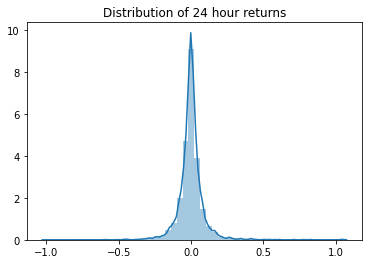

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(dp['Returns'].values, hist=True)
plt.title('Distribution of 24 hour returns')

plt.show()

In [22]:
for x in dp['Returns'].values:
    if x =='':
        print('ues')

In [23]:
quarts = dp.Returns.quantile([0.2,0.5,0.8])
print(quarts)

0.2   -0.043336
0.5   -0.000445
0.8    0.040120
Name: Returns, dtype: float64


In [24]:
print(quarts[0.2])
print(quarts[0.5])
print(quarts[0.8])

#0 is short
#1 is hold
#2 is buy

def label_signal (row):
    if row['Returns'] <= quarts[0.2]:
        return 0
    elif row['Returns'] <= quarts[0.8]:
        return 1
    else:
        return 2

dp['Signal'] = dp.apply (lambda row: label_signal(row), axis=1)

-0.0433364584689252
-0.00044523597506673784
0.040120117173748866


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=0.0001) #feature extraction function buildup
result=cv.fit_transform(texts_new)  #transform the data into document-term matrix
name=cv.get_feature_names() #feature name
X=result.toarray() #prepare for the data in matrix
y = dp['Signal'].tolist()
print(len(texts_new))
print(len(y))

3349
3349


# Train Test Split Manually For Time Series Data

In [26]:
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]


[1,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 2,


In [27]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned huperparameter :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/home/block/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/block/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/block/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/block/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/block/anaconda3/lib/python3.8/site-

/home/block/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/block/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/block/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/block/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/block/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/block/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/block/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/block/anaconda3/lib/python3.8

/home/block/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/block/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.5797635933806146


In [30]:
zero = 0
two = 0
res = logreg_cv.predict(X_test)
for x in res:
    if x ==0:
        zero +=1
    if x ==2:
        two +=1
print('buy recomendations: '+str(two))
print('short recomendations: '+str(zero))

        

buy recomendations: 53
short recomendations: 44


In [112]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


parameters = { 'max_iter': [1000,1100], 'alpha': 10.0 ** -np.arange(3, 7), 'hidden_layer_sizes':np.arange(2, 3), 'random_state':[0,1,2]}
MLP = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1,verbose=10)

result_mlp = MLP.fit(X_train, y_train)
print('MLP regression for in-sample and out-of-sample cases:')
print(accuracy_score(result_mlp.predict(X_train),y_train))
print(accuracy_score(result_mlp.predict(X_test),y_test))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 65.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 84.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 97.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 117.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 136.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 159.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 178.7min finished


MLP regression for in-sample and out-of-sample cases:
0.9893344709897611
0.5472636815920398


In [144]:
mlpreds = MLP.predict(X_test)
zero = 0
two = 0
one=0
for x in mlpreds:
    if x ==0:
        zero +=1
    if x ==2:
        two +=1
    if x==1:
        one +=1
print('buy recomendations: '+str(two))
print('short recomendations: '+str(zero))
print('hold recomendations: '+str(one))


buy recomendations: 60
short recomendations: 145
hold recomendations: 800


In [145]:
MLP.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': 2, 'max_iter': 1000, 'random_state': 0}

# Multilayer-Perceptron

In [146]:
sd = dp.tail(1005)
sd['preds'] = mlpreds
sd = sd.sort_values(by=['Bought'],ascending=True)

<ipython-input-146-86c7dcd0b89e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sd['preds'] = mlpreds


In [154]:
#1000 pound portfolio stocks selected
#Lock all funds into it
#funds are only locked when buying 
sd = dp.tail(1005)
sd['preds'] = mlpreds
sd = sd.sort_values(by=['Bought'],ascending=True)
balance = 1000
locked = False
lockeduntil = sd['Bought'].min()
results = []

results = []

for x in sd.iterrows():
    pred = x[1]['preds']
    returns = x[1]['Returns']
    basetime = x[1]['Bought']
    lockingtime = x[1]['Sold']
    #if buy

    if basetime > lockeduntil:
        if pred == 2:
            lockeduntil = lockingtime
            balance = balance * (1+returns)
            dt_object = datetime.fromtimestamp(lockeduntil)
            results.append([balance,dt_object])
        else:
            dt_object = datetime.fromtimestamp(lockeduntil)
            results.append([balance,dt_object])
    else:
        dt_object = datetime.fromtimestamp(lockeduntil)
        results.append([balance,dt_object])

 
    
    #in the case of shorting you need the money at the expiry date of 24 hours
    if lockingtime > lockeduntil:   
        if pred == 0:
            balance = balance * (1-returns)
            dt_object = datetime.fromtimestamp(lockeduntil)
            results.append([balance,dt_object])
        else:
            dt_object = datetime.fromtimestamp(lockeduntil)
            results.append([balance,dt_object])
    else:
        dt_object = datetime.fromtimestamp(lockeduntil)
        results.append([balance,dt_object])


print(balance)

114.93876685830742


<ipython-input-154-0cd2c075edb5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sd['preds'] = mlpreds


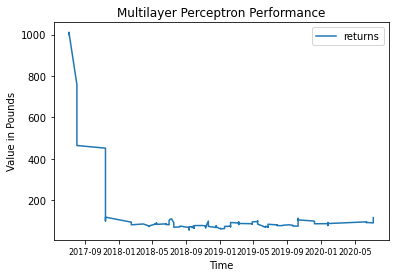

<Figure size 432x288 with 0 Axes>

In [157]:
mlp = pd.DataFrame(data=results, columns=['Value','Time'])
x = mlp['Time'].values
y = mlp['Value'].values

plt.plot(x, y, label='returns')
# Add a legend
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value in Pounds")
plt.tick_params(axis='x',labelsize=8)
plt.title('Multilayer Perceptron Performance')
# Show the plot
plt.show()
plt.savefig('MultiLayer.png')

# Logisitic Regression

In [159]:
res = logreg_cv.predict(X_test)
sd = dp.tail(1005)
sd['preds'] = res
sd = sd.sort_values(by=['Bought'],ascending=True)

balance = 1000
locked = False
lockeduntil = sd['Bought'].min()

results = []

for x in sd.iterrows():
    pred = x[1]['preds']
    returns = x[1]['Returns']
    basetime = x[1]['Bought']
    lockingtime = x[1]['Sold']
    #if buy

    if basetime > lockeduntil:
        if pred == 2:
            lockeduntil = lockingtime
            balance = balance * (1+returns)
            dt_object = datetime.fromtimestamp(lockeduntil)
            results.append([balance,dt_object])
        else:
            dt_object = datetime.fromtimestamp(lockeduntil)
            results.append([balance,dt_object])
    else:
        dt_object = datetime.fromtimestamp(lockeduntil)
        results.append([balance,dt_object])

 
    
    #in the case of shorting you need the money at the expiry date of 24 hours
    if lockingtime > lockeduntil:   
        if pred == 0:
            balance = balance * (1-returns)
            dt_object = datetime.fromtimestamp(lockeduntil)
            results.append([balance,dt_object])
        else:
            dt_object = datetime.fromtimestamp(lockeduntil)
            results.append([balance,dt_object])
    else:
        dt_object = datetime.fromtimestamp(lockeduntil)
        results.append([balance,dt_object])


print(balance)


3071.9998325097563


<ipython-input-159-a71904fdf2b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sd['preds'] = res


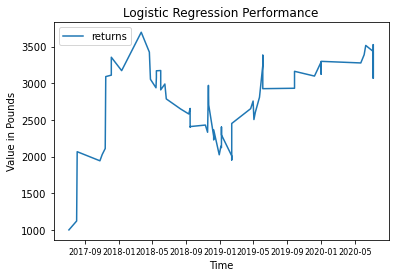

In [160]:
lgdfplt = pd.DataFrame(data=results, columns=['Value','Time'])
x = lgdfplt['Time'].values
y = lgdfplt['Value'].values

plt.plot(x, y, label='returns')
# Add a legend
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value in Pounds")
plt.tick_params(axis='x',labelsize=8)
plt.title('Logistic Regression Performance')
# Show the plot
plt.show()
